In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, stft
from scipy.fft import rfft, fftfreq, rfftfreq, irfft
import pywt
from scipy.signal.windows import hann
from scipy.io import wavfile
import os
import glob
import librosa

In [3]:
# Folder path given to cover both Abnormal and Normal Folders

folder_path = './train/*/'

In [4]:
# Getting all the .wav files inside the folder
wav_files = glob.glob(os.path.join(folder_path, '*.wav'))

In [5]:
# Setting the target duration and initializing other parameters
L = 4 # Target duration set according to the shortest file
target_samples = None

In [6]:
# Storing the signals and their corresponding time vectors in a list
data = []
file_info = [] # Storing file paths for plotting

In [7]:
# Looping over each .wav file to plot data
for wav_file in wav_files:
    print(f"Processing file: {wav_file}")   
    
    # Reading the .wav file
    x, fs = librosa.load(wav_file, sr=44100)  # Heartbeat sample rate is 44.1kHz
    
    if target_samples is None:
        # Calculating the number of samples corresponding to 4 seconds based on fs
        target_samples = int(L * fs)

    # Checking if the signal is shorter or longer than the target number of samples
    if len(x) < target_samples:
        # Padding the signal with zeros if it's shorter than 4 seconds
        x_padded = np.pad(x, (0, target_samples - len(x)), mode='constant')
        x = x_padded
    elif len(x) > target_samples:
        # Truncating the signal if it's longer than 4 seconds
        x = x[:target_samples]

    # Update the time axis to match the new length (fixed to 4 seconds)
    t = np.arange(0, L, 1/fs)
    data.append((t, x))
    file_info.append(wav_file) # Storing the file path to be used in plot

Processing file: ./train\Abnormal\(1).wav
Processing file: ./train\Abnormal\(11).wav
Processing file: ./train\Abnormal\(2).wav
Processing file: ./train\Abnormal\(3).wav
Processing file: ./train\Abnormal\(4).wav
Processing file: ./train\Normal\(1).wav
Processing file: ./train\Normal\(11).wav
Processing file: ./train\Normal\(12).wav
Processing file: ./train\Normal\(3).wav
Processing file: ./train\Normal\(6).wav


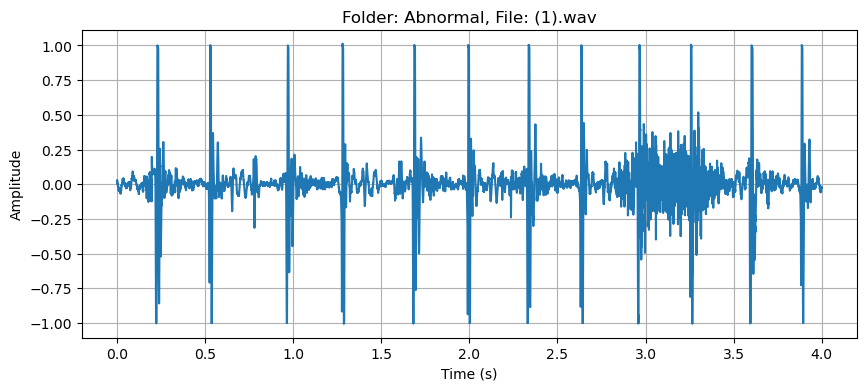

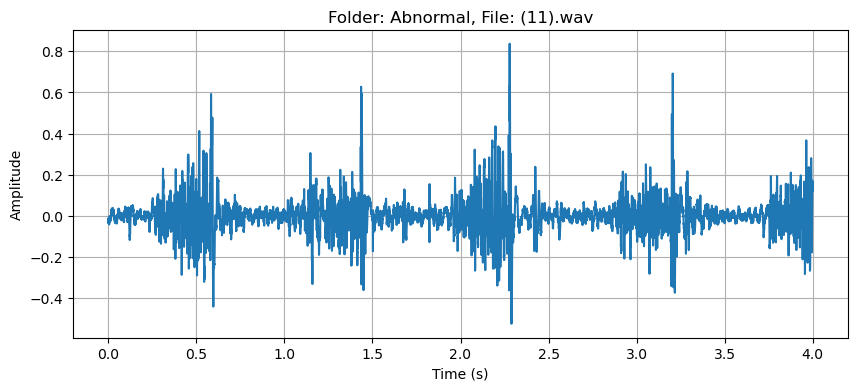

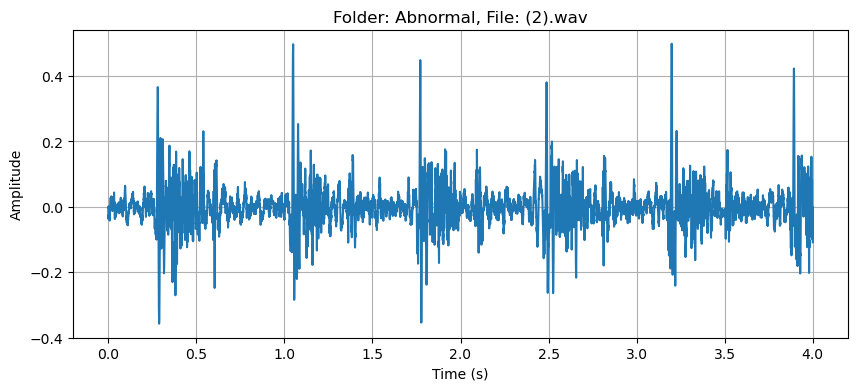

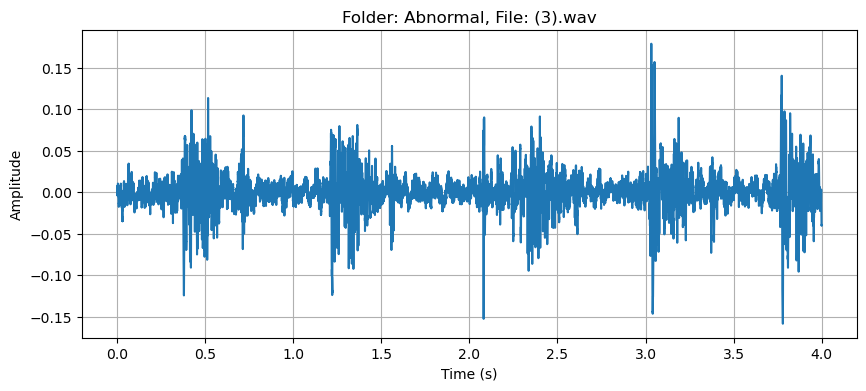

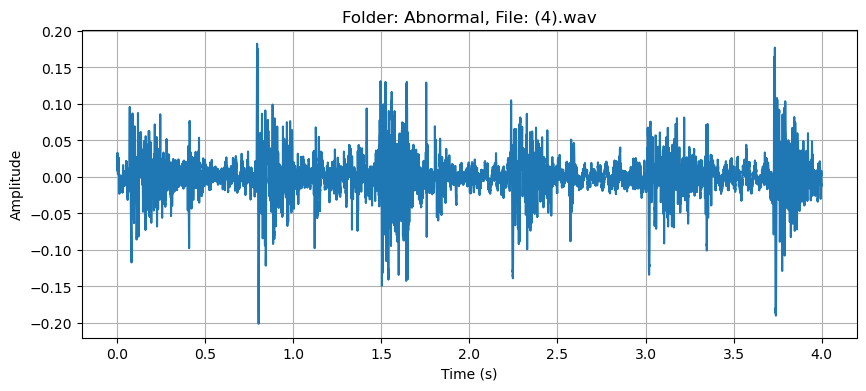

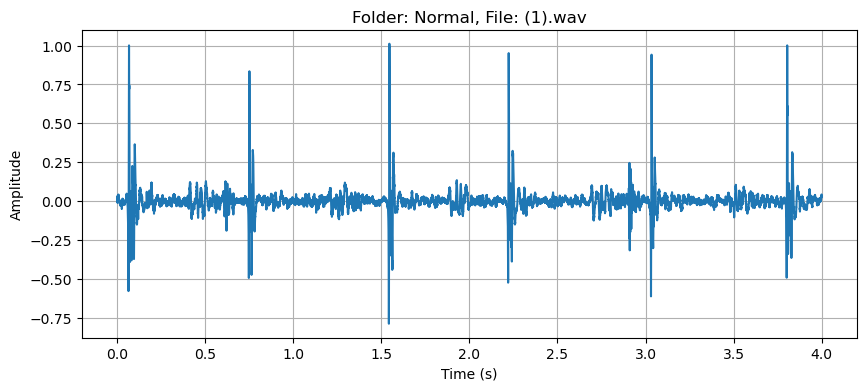

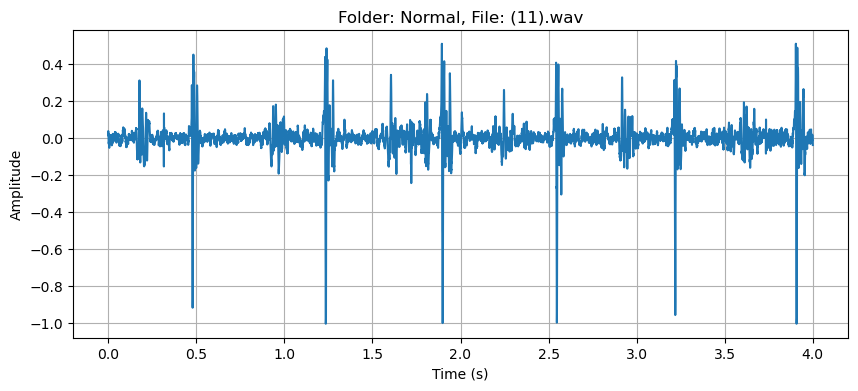

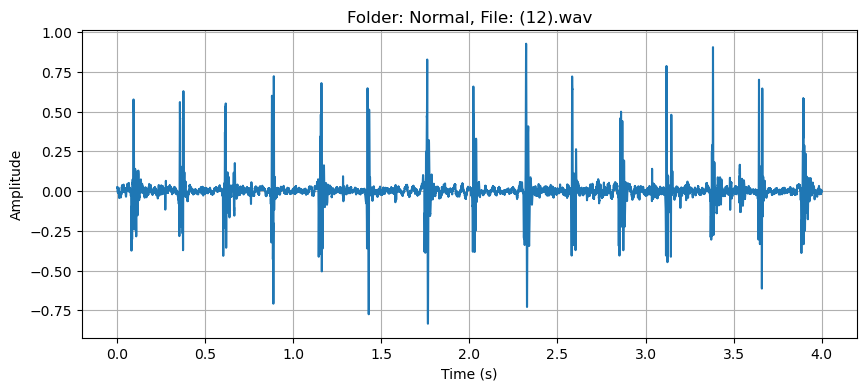

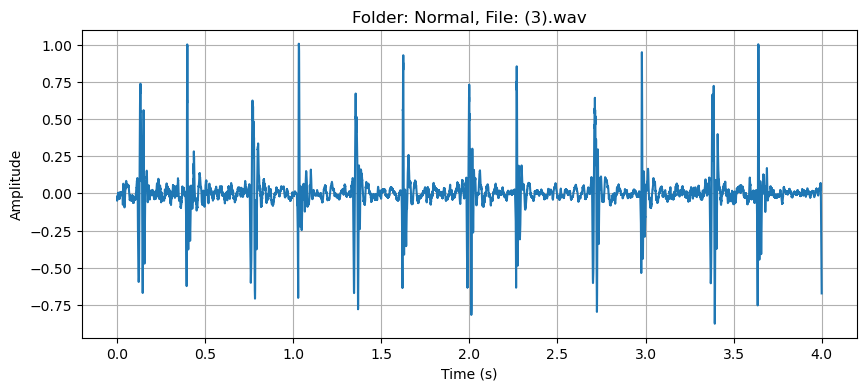

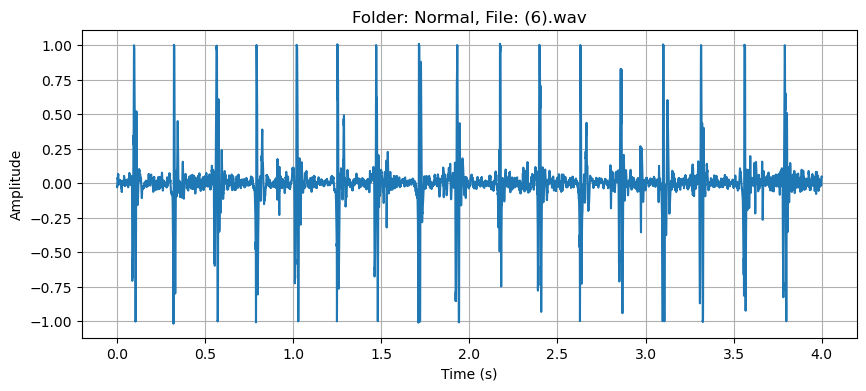

In [8]:
# Plot each signal
for i, (t, x) in enumerate(data):
    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    plt.figure(figsize=(10, 4))
    plt.plot(t, x)
    plt.title(f'Folder: {folder_name}, File: {file_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

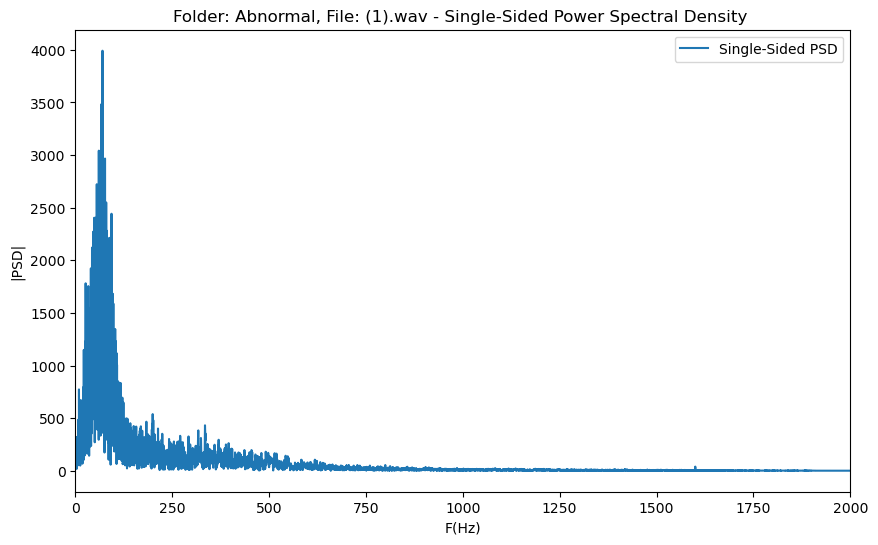

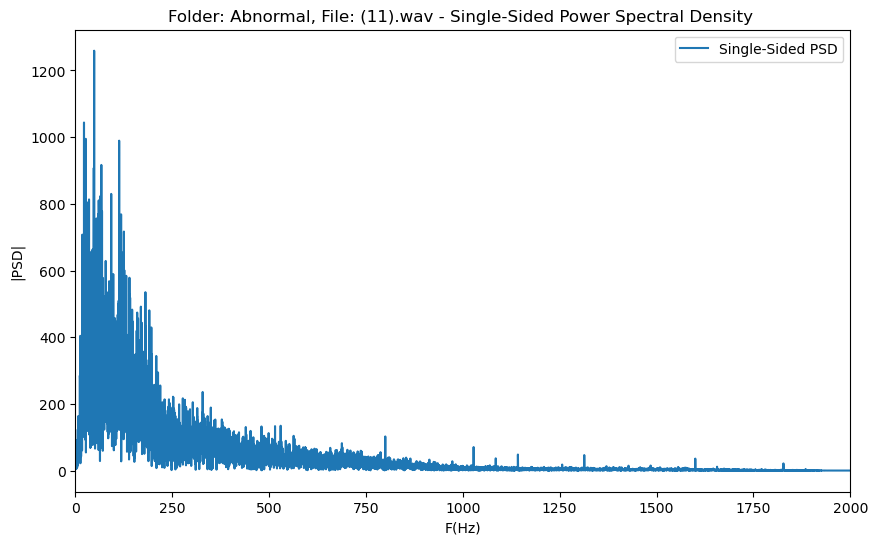

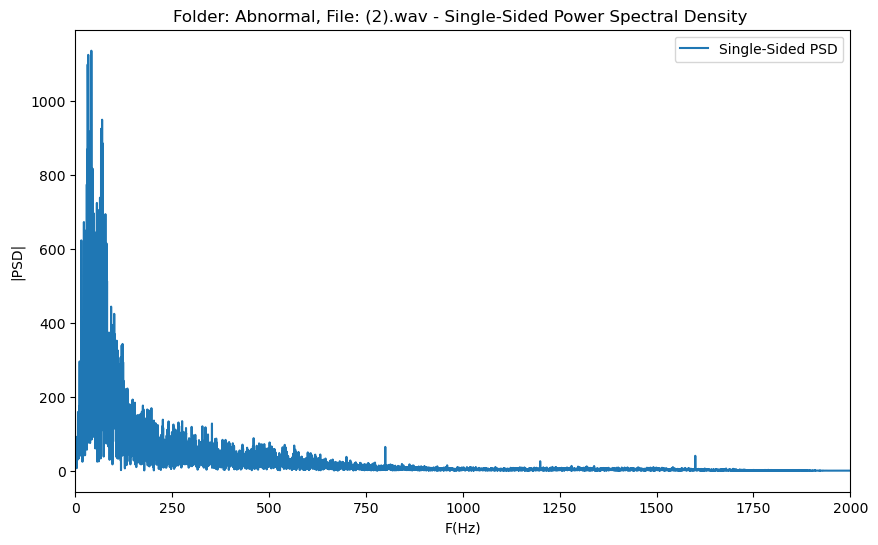

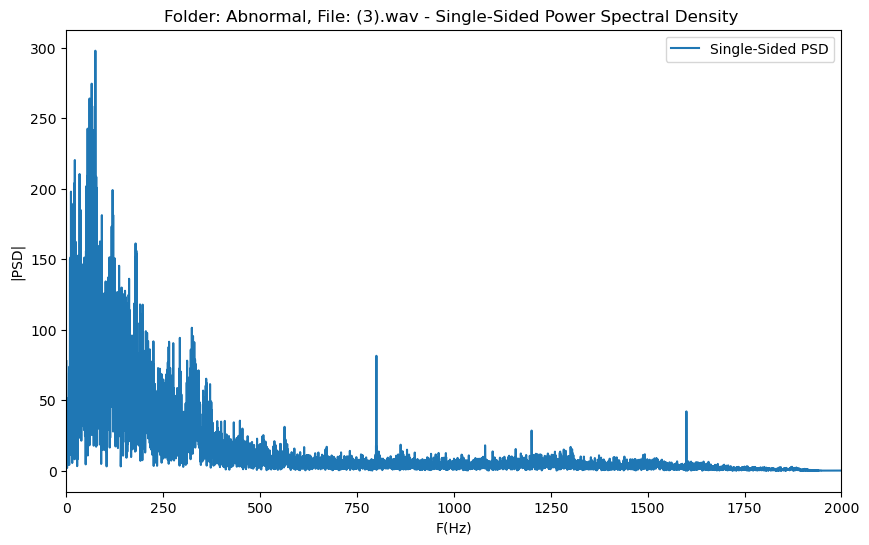

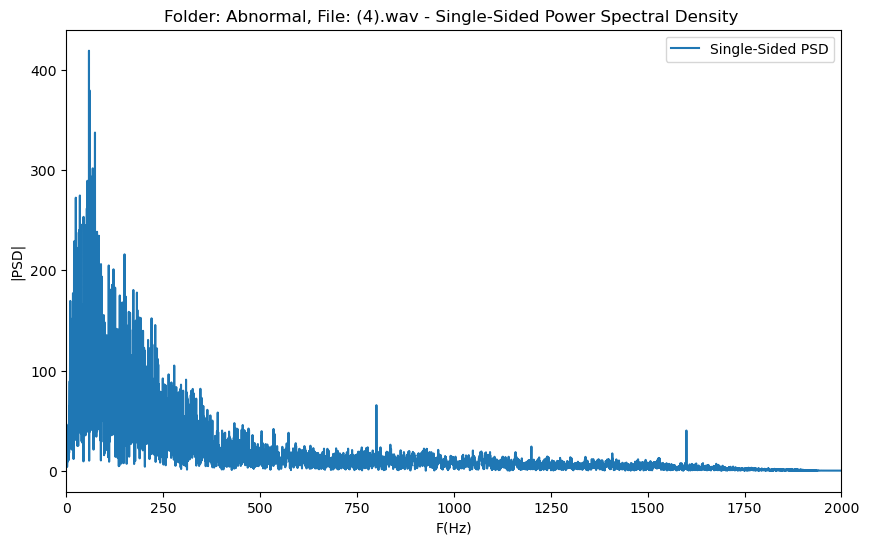

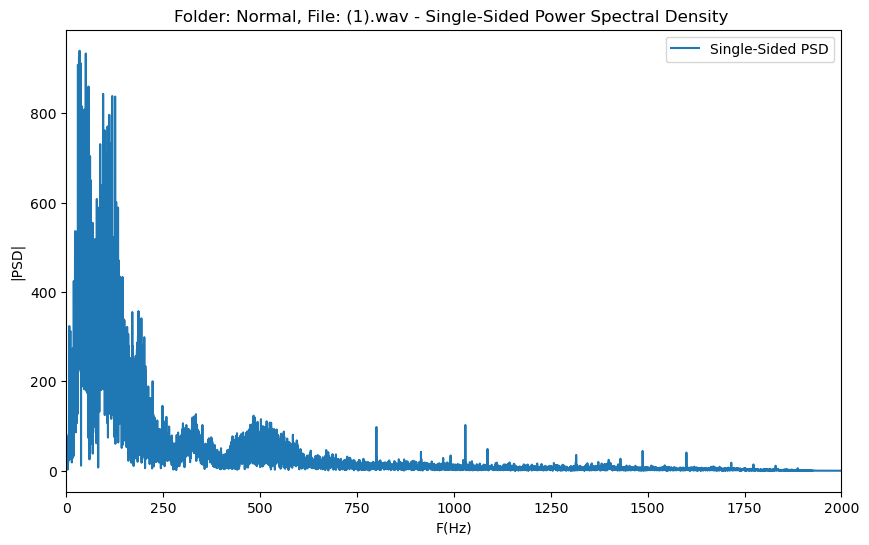

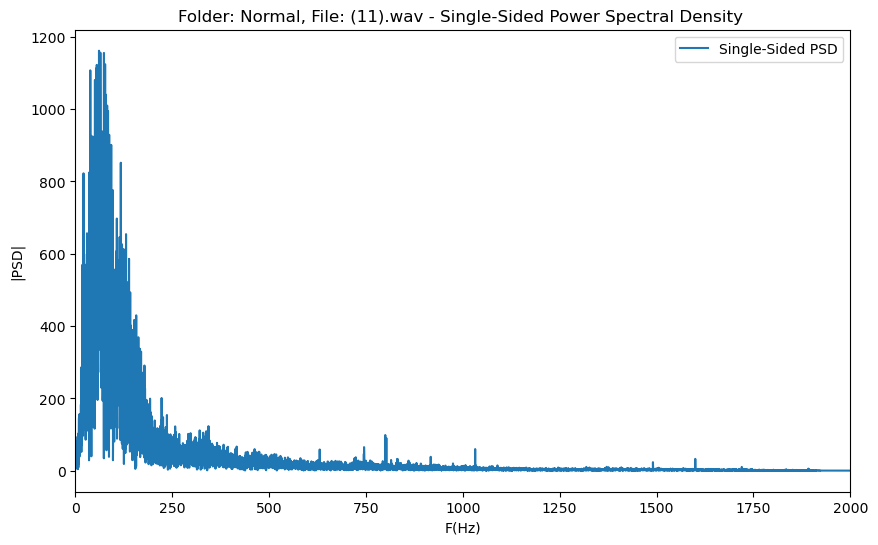

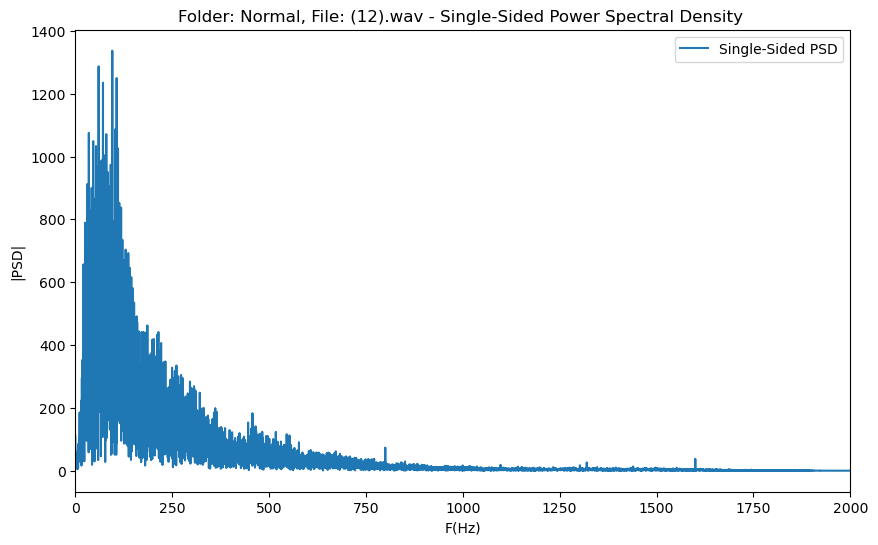

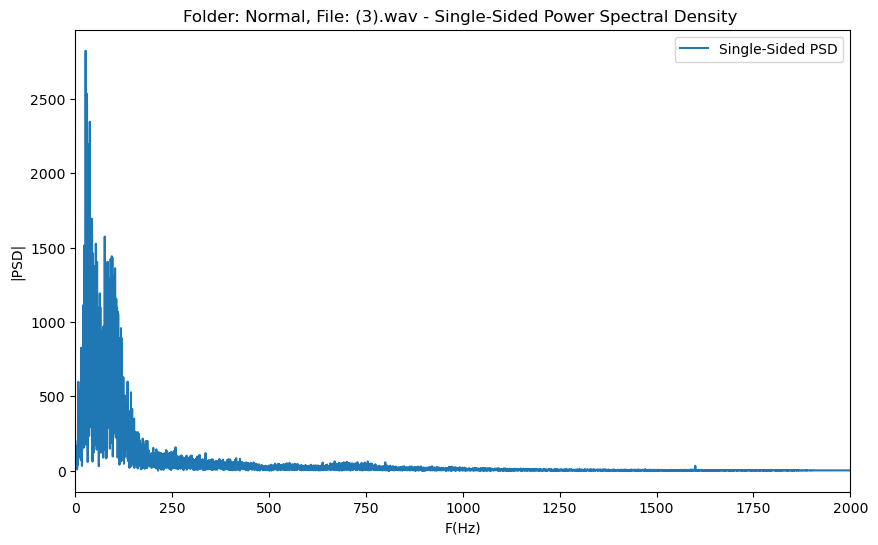

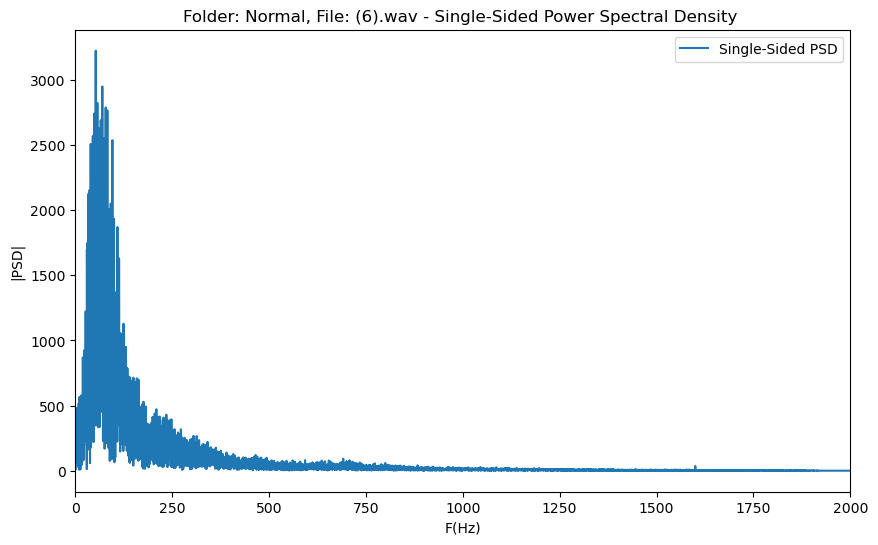

In [23]:
# Function to perform FFT analysis
for i, (t, x) in enumerate(data):
    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    Y = rfft(x)  # Compute the fast Fourier transform (rfft()  returns only half the output that fft() does)
    PSD = np.abs(Y) # Calculate the Power spectrum

    freqs = rfftfreq(t.size, 1/fs)

    #Plotting Single-Sided Power Spectral Density
    plt.figure(figsize = (10, 6))
    plt.plot(freqs, PSD, label = 'Single-Sided PSD')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Single-Sided Power Spectral Density ')
    plt.xlabel('F(Hz)')
    plt.ylabel('|PSD|')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.xlim(0, 2000) # Focusing on the relevant data region
    plt.show()


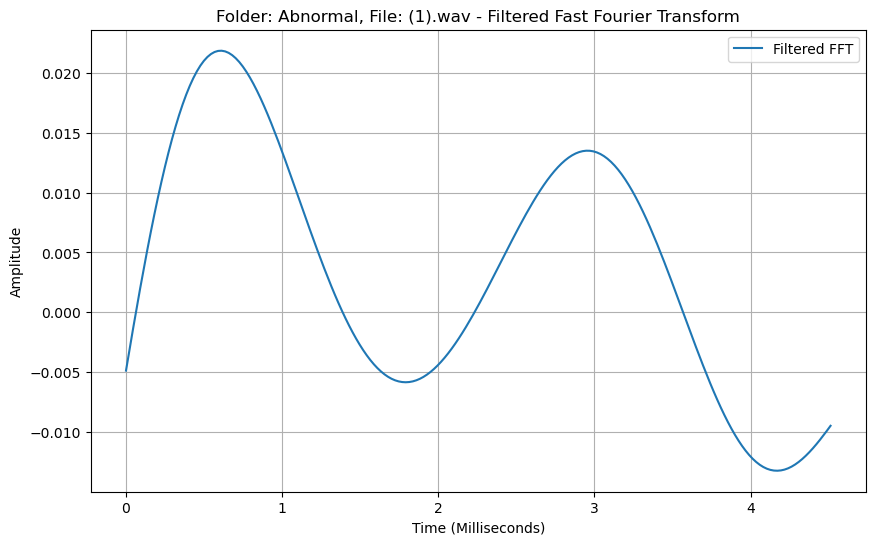

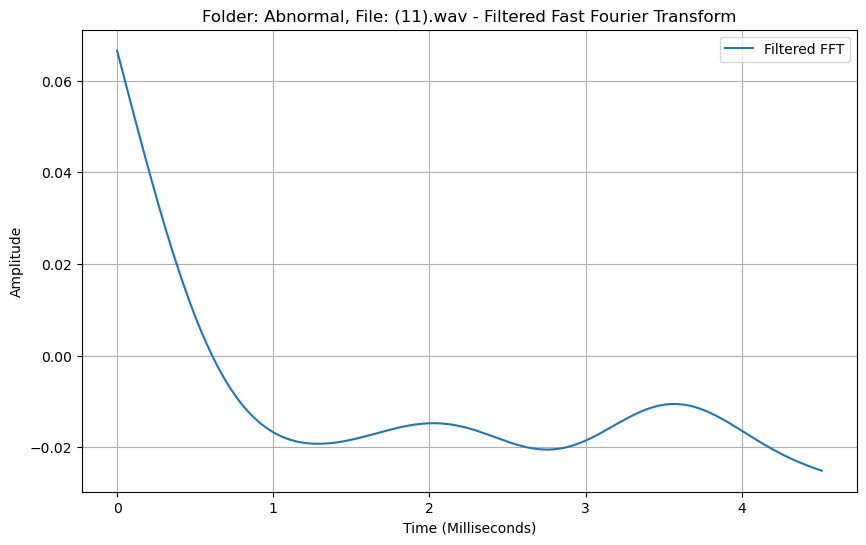

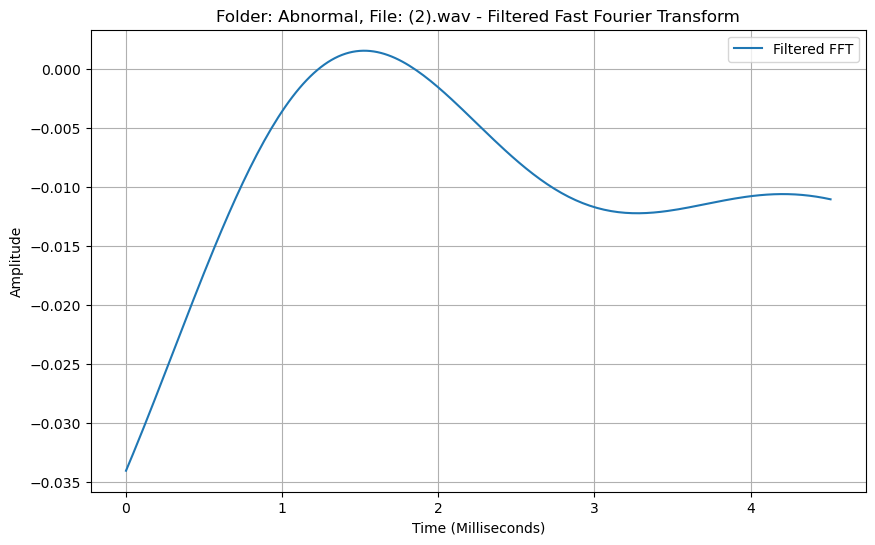

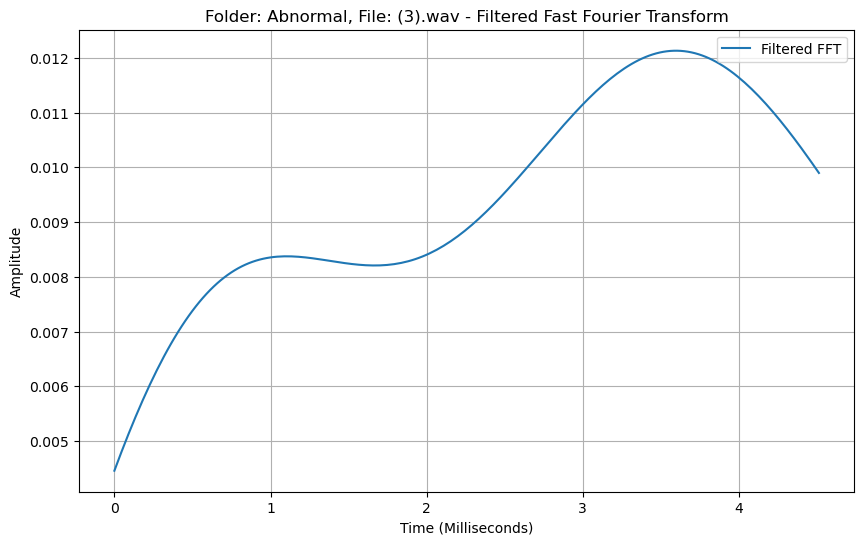

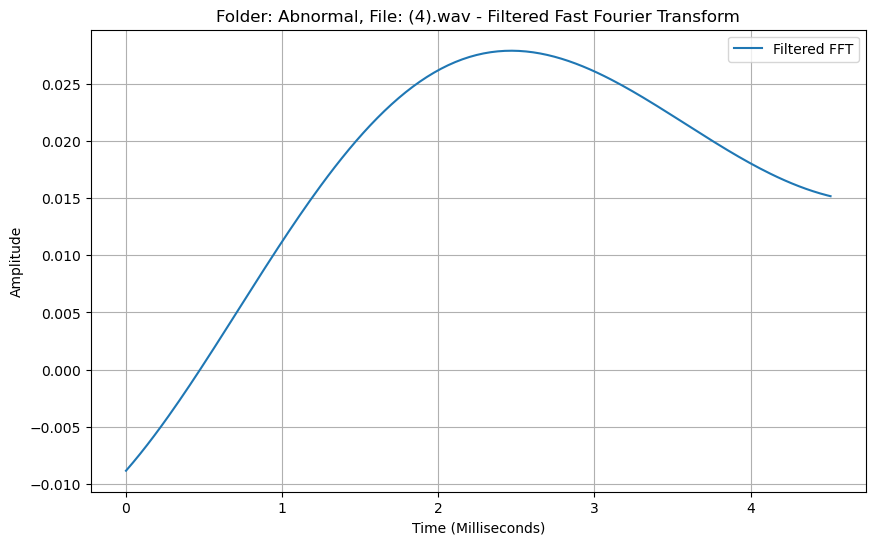

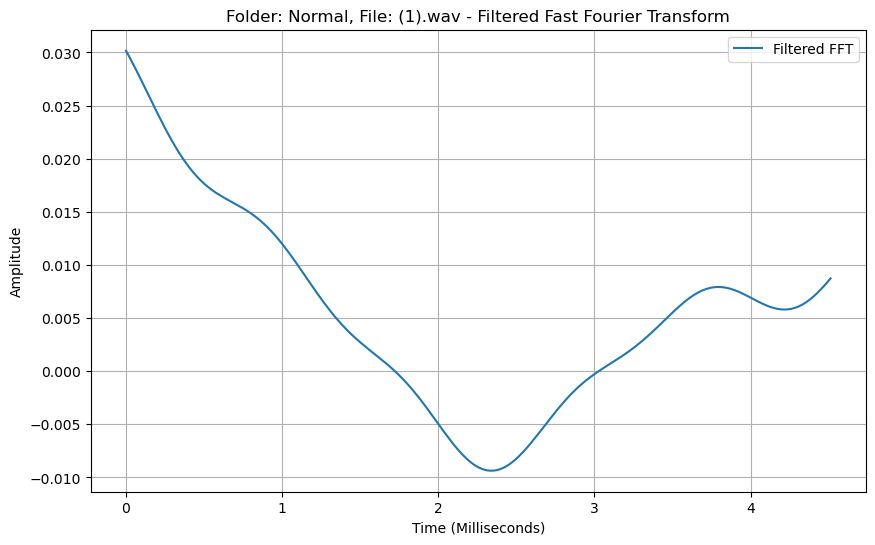

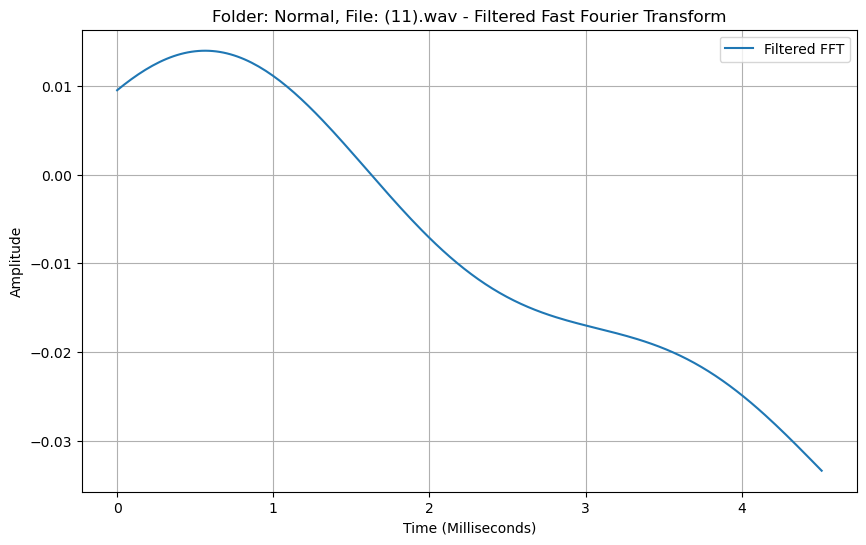

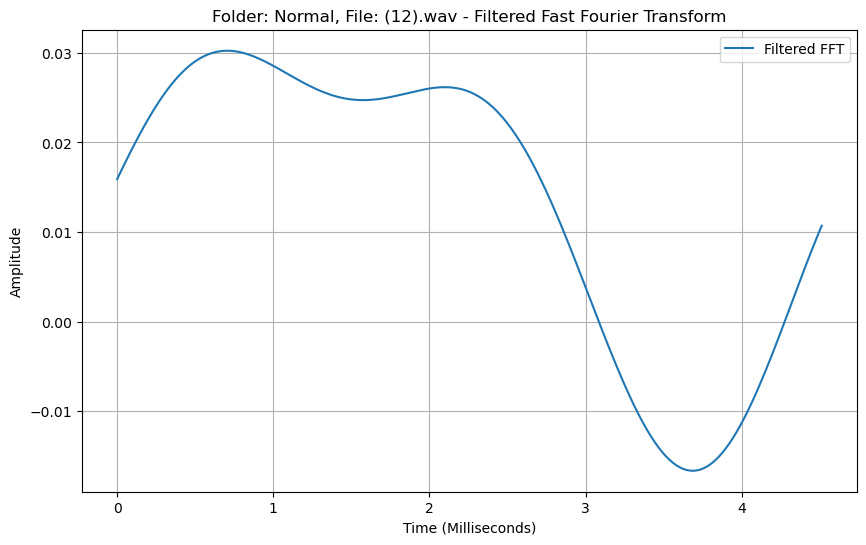

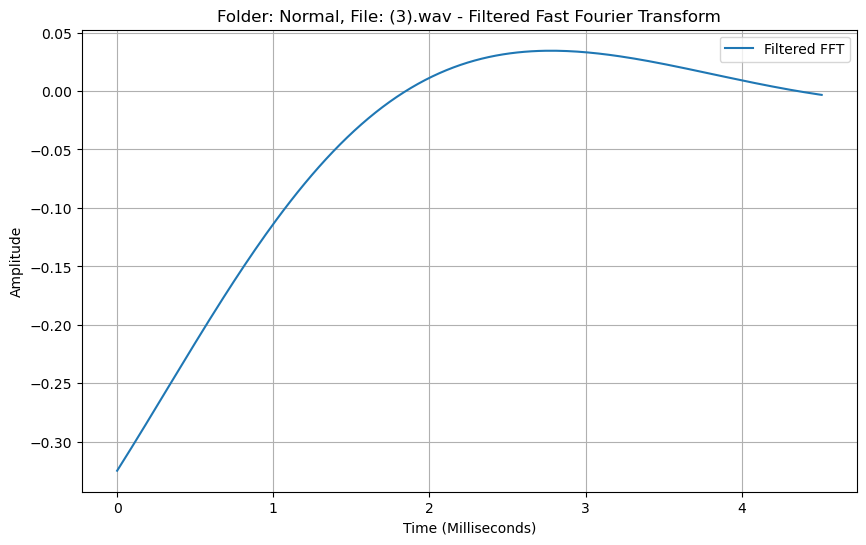

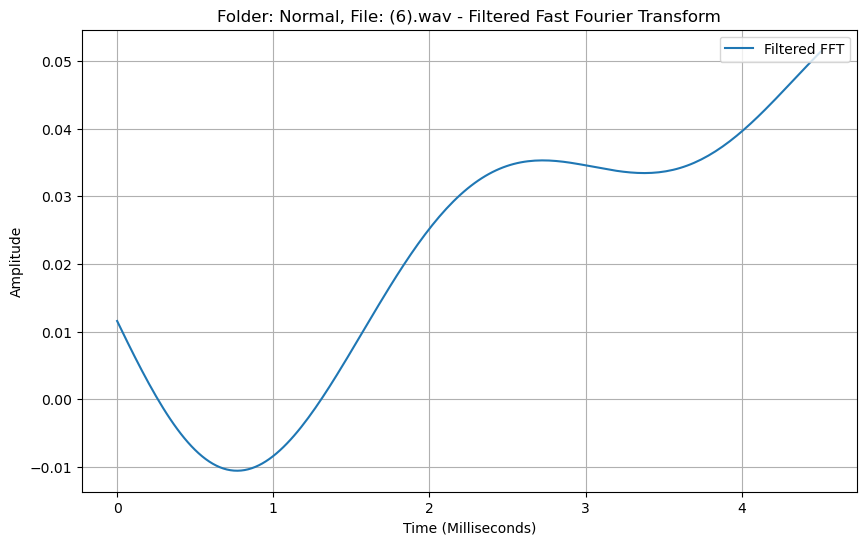

In [29]:
# Plot the FFT
for i, (t, x) in enumerate(data):
    #Assigning Threshold Value
    threshold = 100

    # Recomputing FFT and PSD for each signal
    Y = rfft(x)  # Compute FFT
    PSD = np.abs(Y)  # Power Spectrum

    #Finding Freqs With Large PSD
    #Taking Out Small Fourier Coeffs In Y
    indices = PSD > threshold
    Y_zeroed = indices * Y

    #Assigning Filtered FFT (FFILT) Value
    #Inverseing FFT For Filtered Time Signal
    ffilt = irfft(Y_zeroed)

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    # Plotting First 200 Filtered Data Points
    t_ms = t[:200] * 1000  # Convert time to milliseconds
    plt.figure(figsize=(10, 6))
    plt.plot(t_ms, ffilt[:200], label='Filtered FFT')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Filtered Fast Fourier Transform')
    plt.xlabel('Time (Milliseconds)')
    plt.ylabel('Amplitude')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True)
    plt.show()

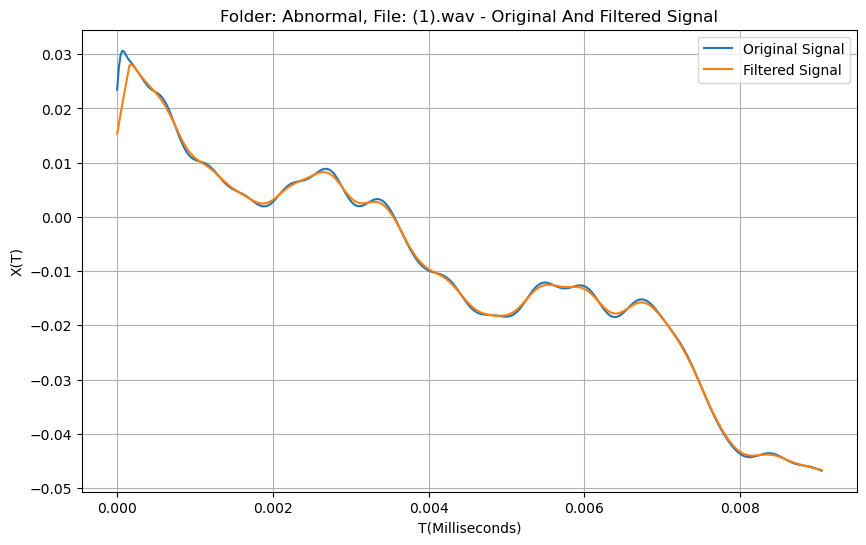

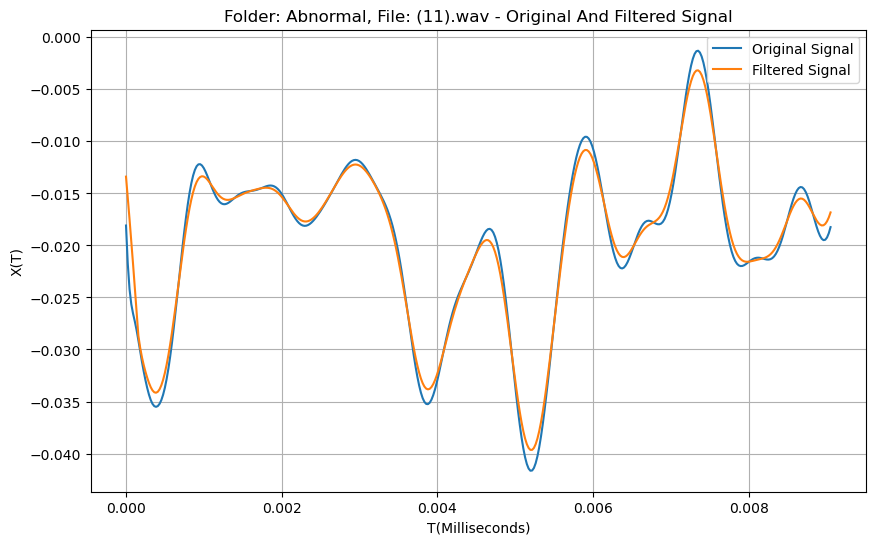

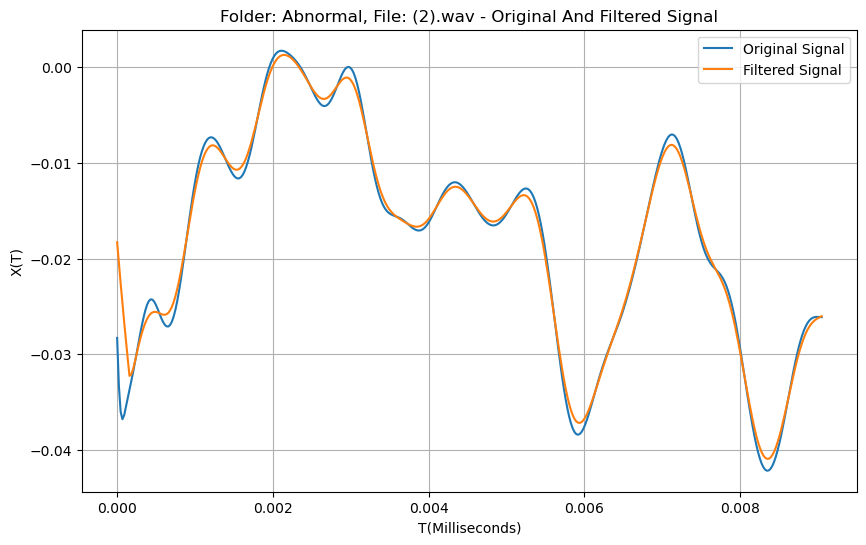

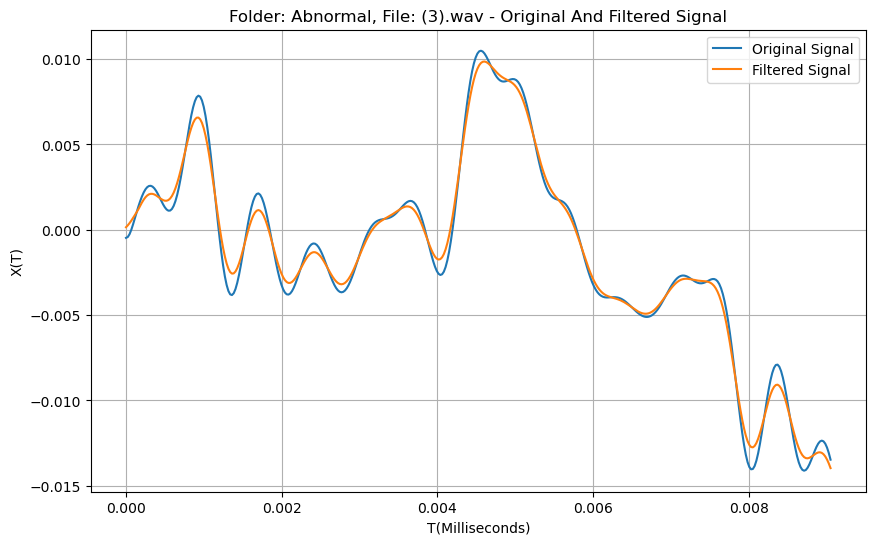

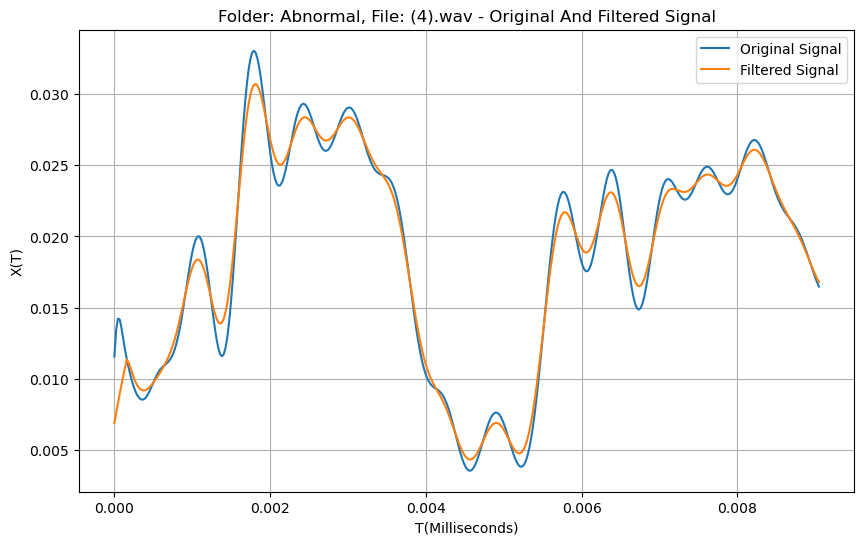

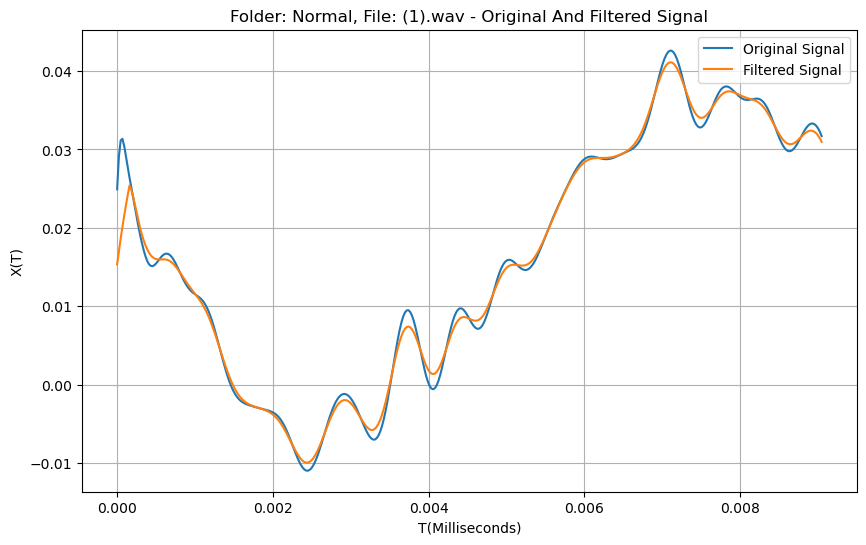

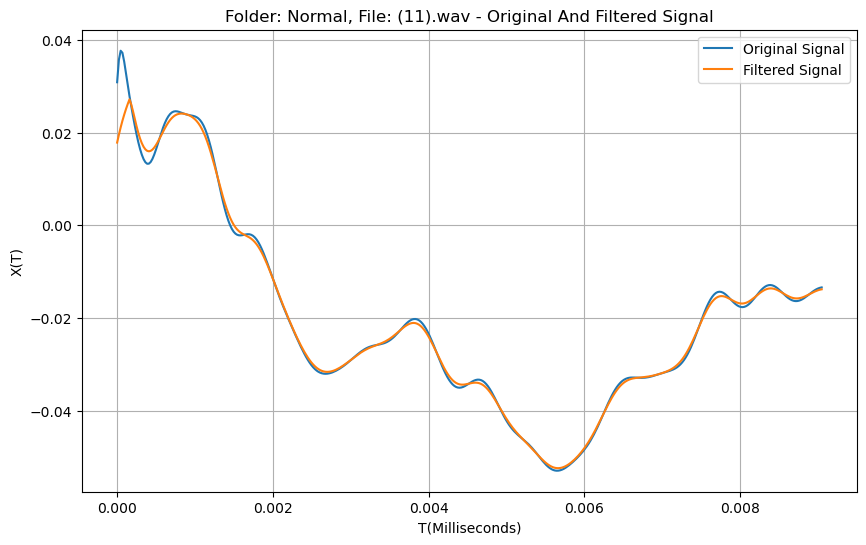

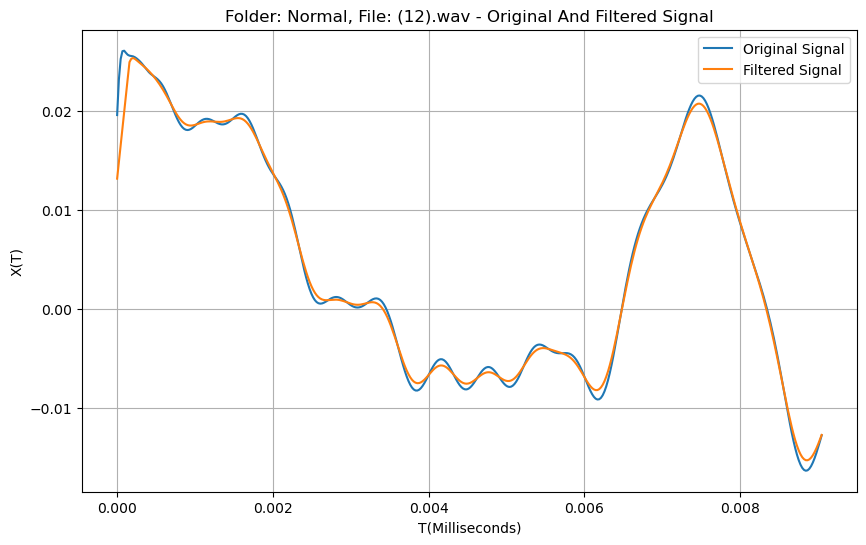

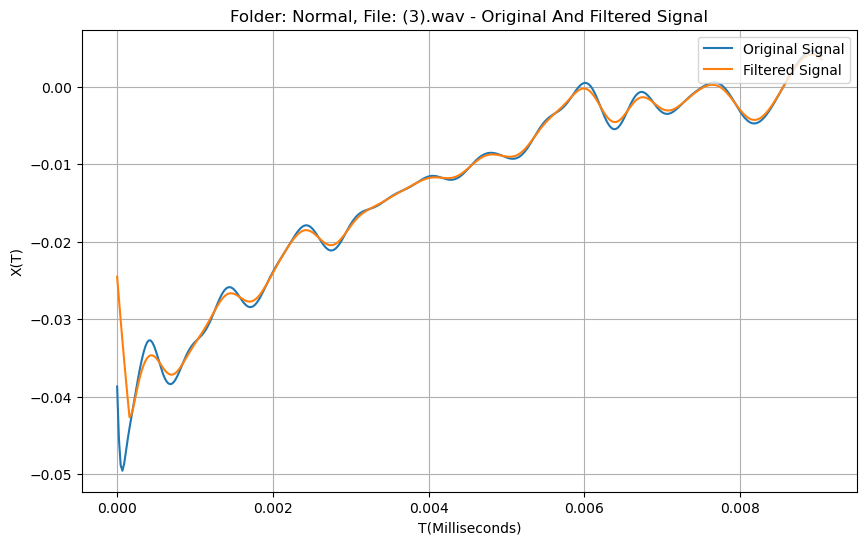

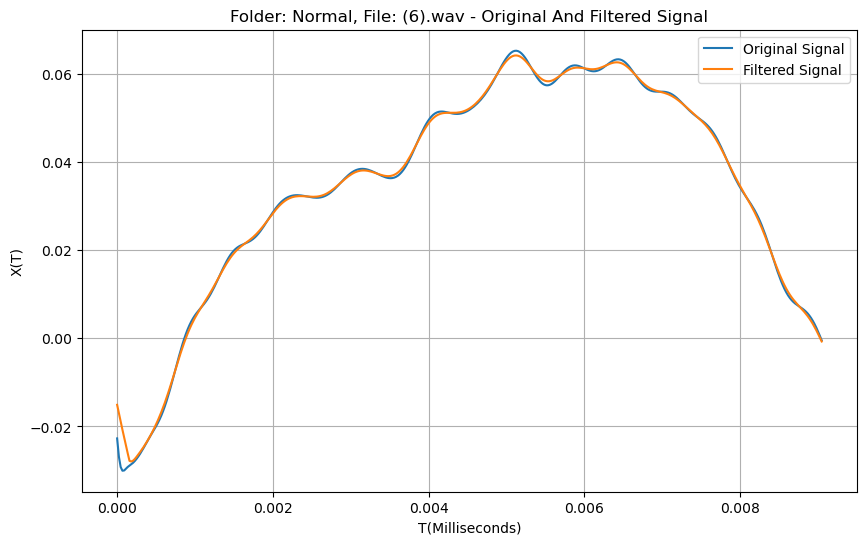

In [30]:
for i, (t, x) in enumerate(data):
    #Defining Size Of Average Filter Kernel
    kernel_size = 15

    #Creating Average Filter Kernel
    average_kernel = np.ones(kernel_size) / kernel_size

    #Convolving Signal With Average Filter Kernel
    S_filtered = np.convolve(average_kernel, x, mode = 'same')

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    #Plotting First 400 Points Of Original And Filtered Signal
    plt.figure(figsize = (10, 6))
    plt.plot(t[:400], x[:400], label = 'Original Signal')
    plt.plot(t[:400], S_filtered[:400], 'tab:orange', label = 'Filtered Signal')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Original And Filtered Signal')
    plt.xlabel('T(Milliseconds)')
    plt.ylabel('X(T)')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.grid()
    plt.show()

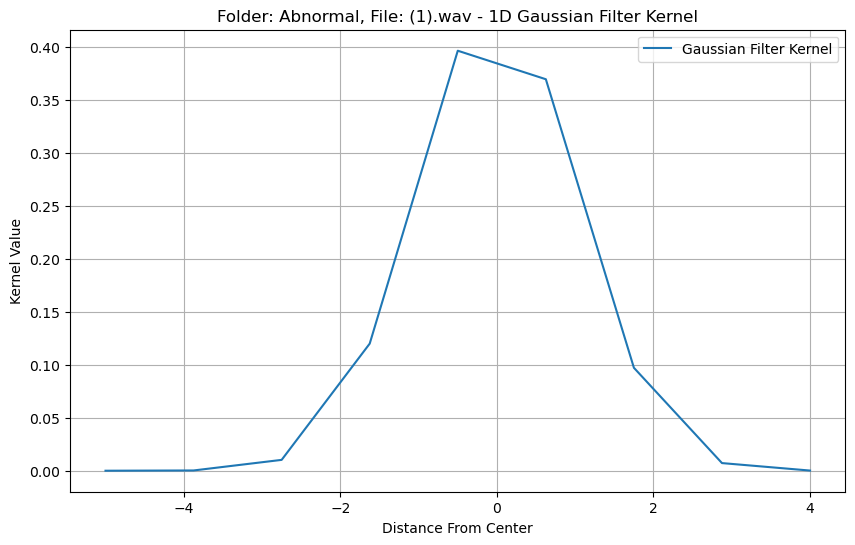

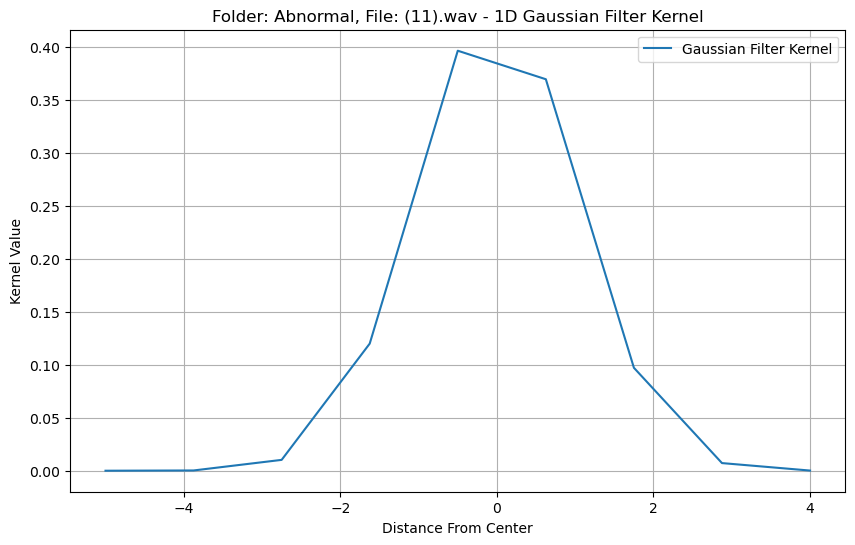

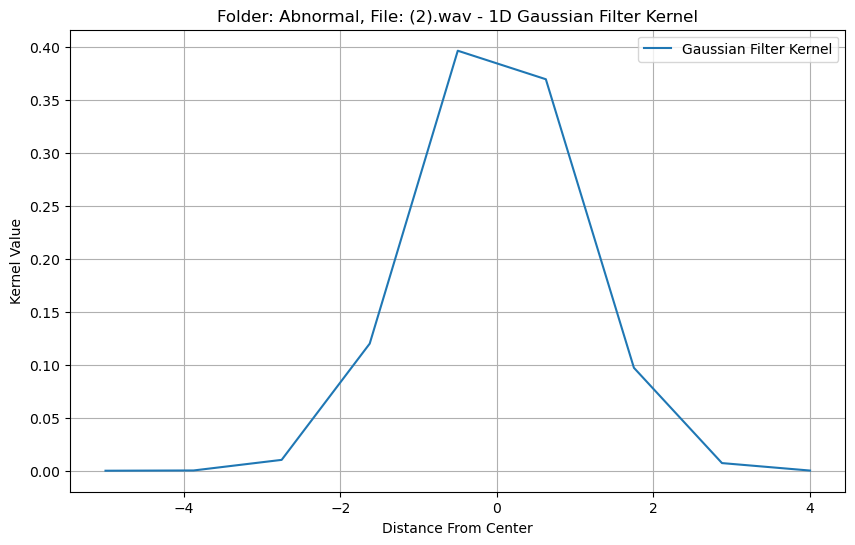

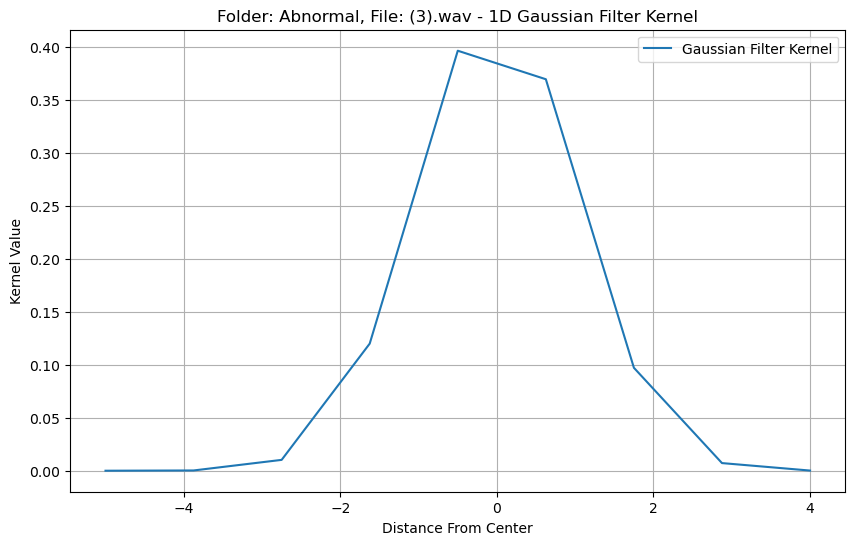

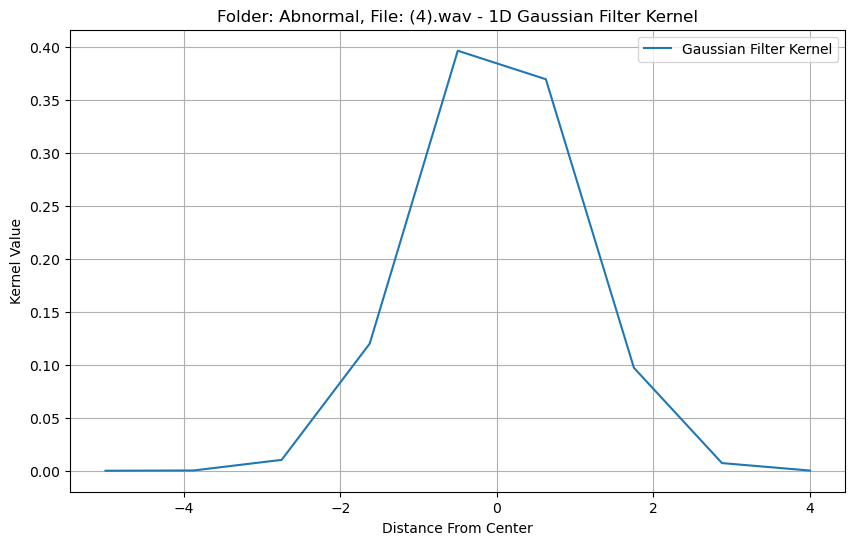

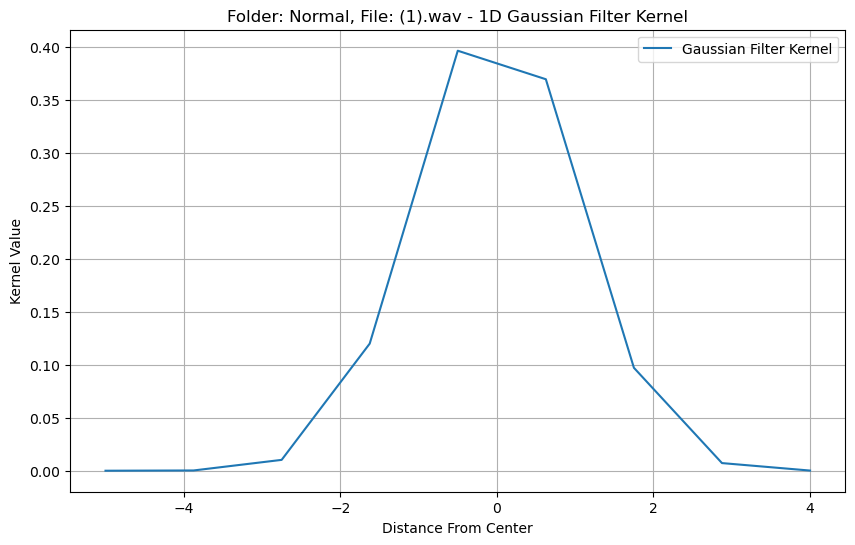

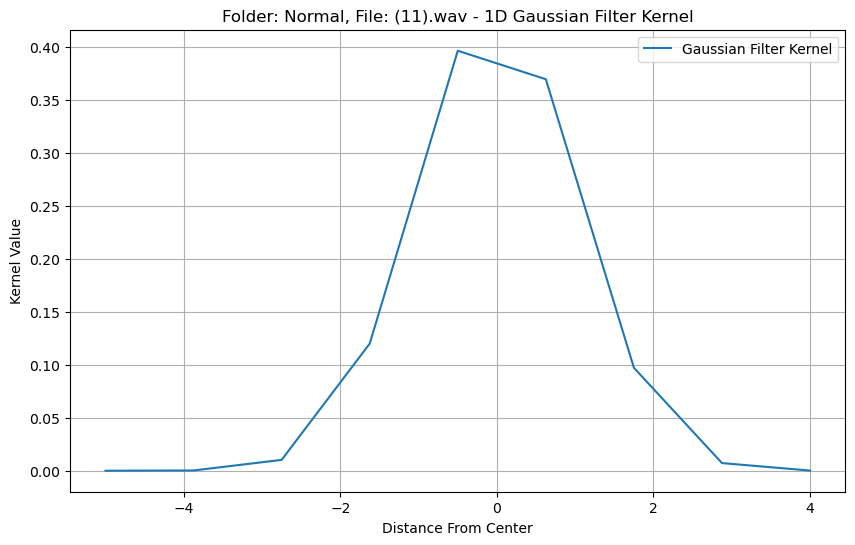

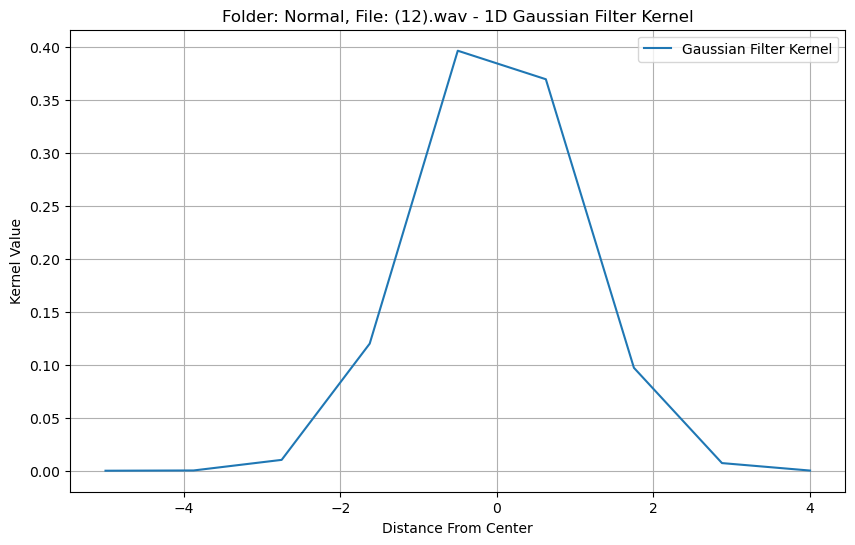

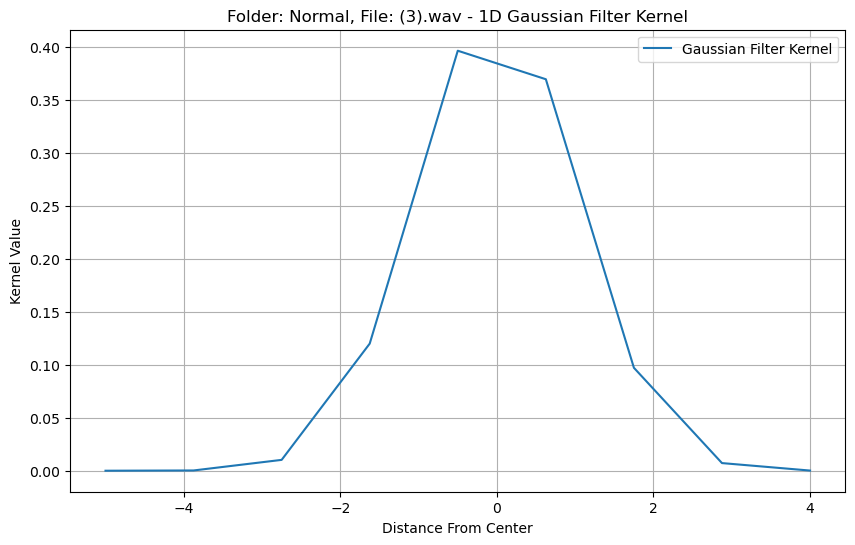

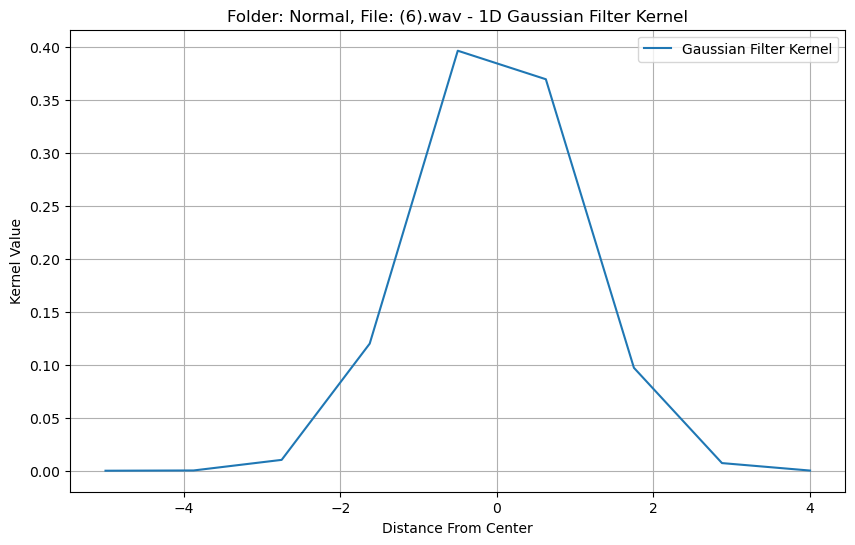

In [32]:
# Plotting the Gaussian Kernel
for i, (t, x) in enumerate(data):
    #Standard Deviation (SD) Of Gaussian Distribution
    sigma = 1.0

    #Filter Size
    filter_size = 9

    #Creating Array Representing 1D Gaussian Kernel
    z = np.linspace(-filter_size // 2, filter_size // 2, filter_size)
    gaussian_kernel = np.exp(-z ** 2 / (2 * sigma ** 2))
    norm_gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    #Plotting Gaussian Kernel
    plt.figure(figsize = (10, 6))
    plt.plot(z, norm_gaussian_kernel, label = 'Gaussian Filter Kernel')
    plt.title(f'Folder: {folder_name}, File: {file_name} - 1D Gaussian Filter Kernel')
    plt.xlabel('Distance From Center')
    plt.ylabel('Kernel Value')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.grid()
    plt.show()

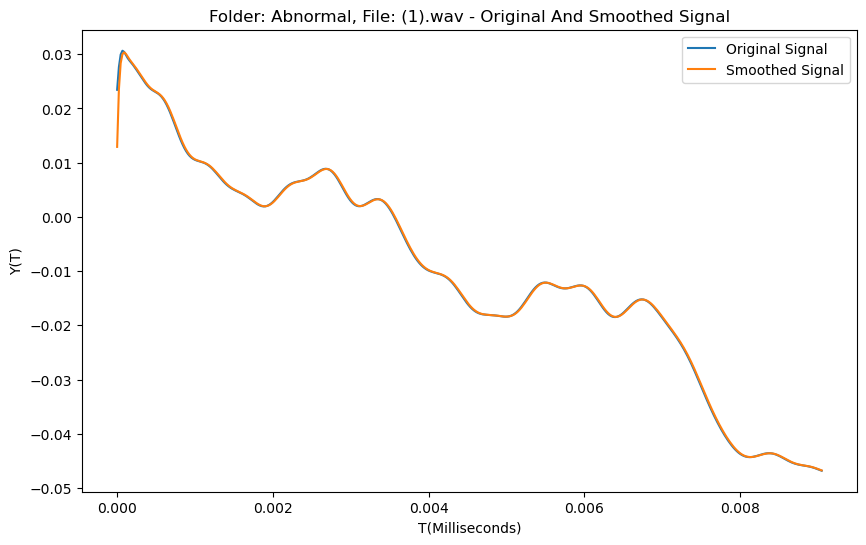

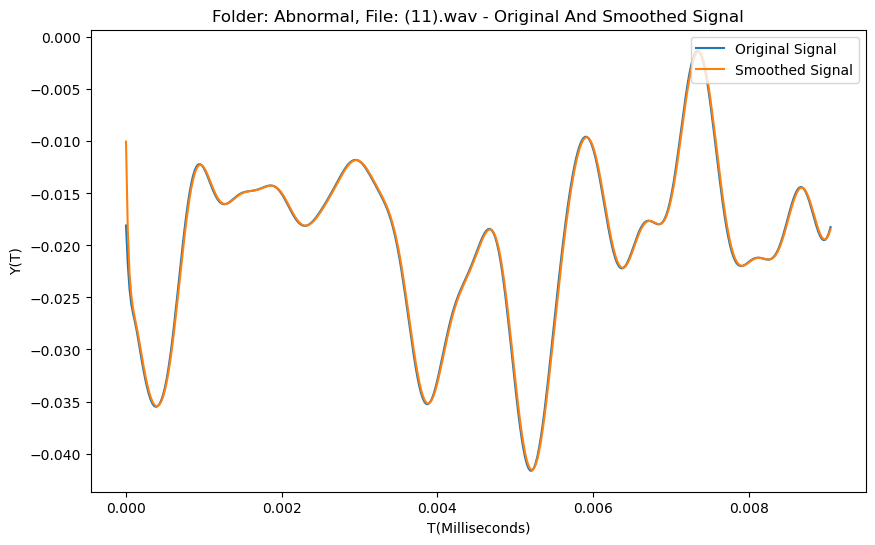

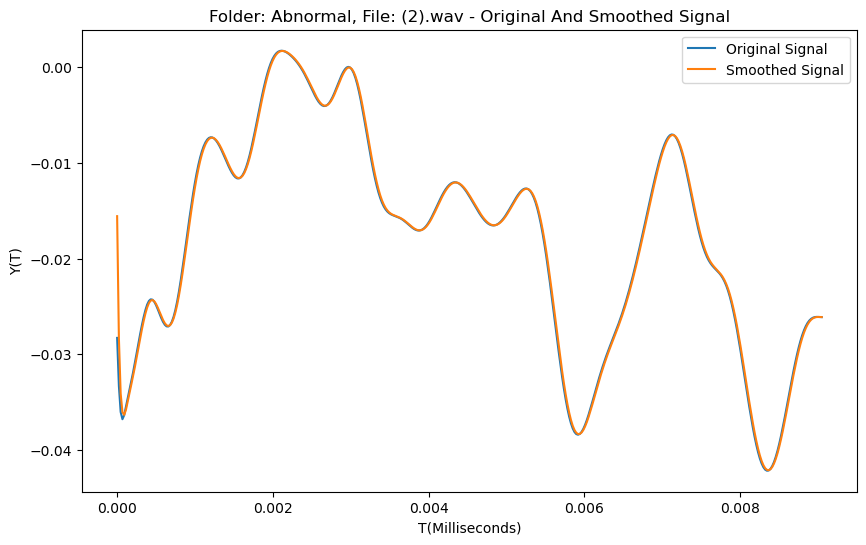

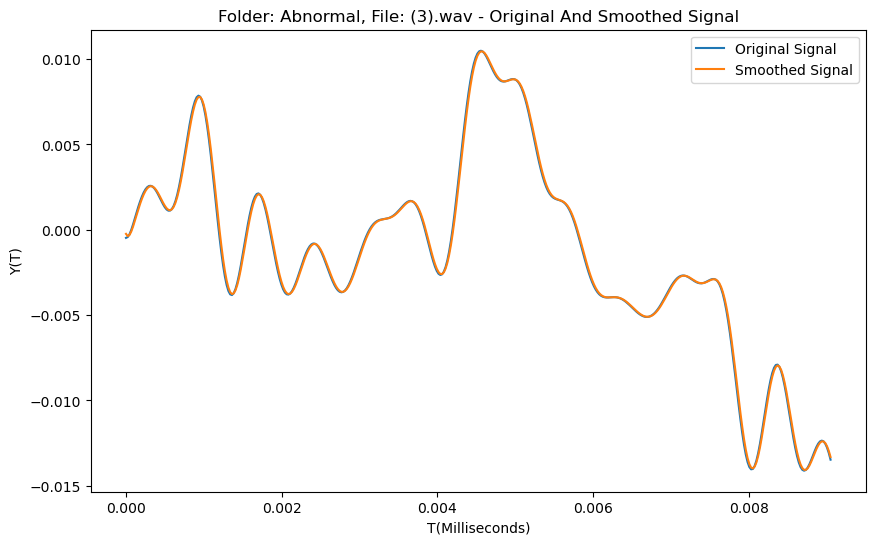

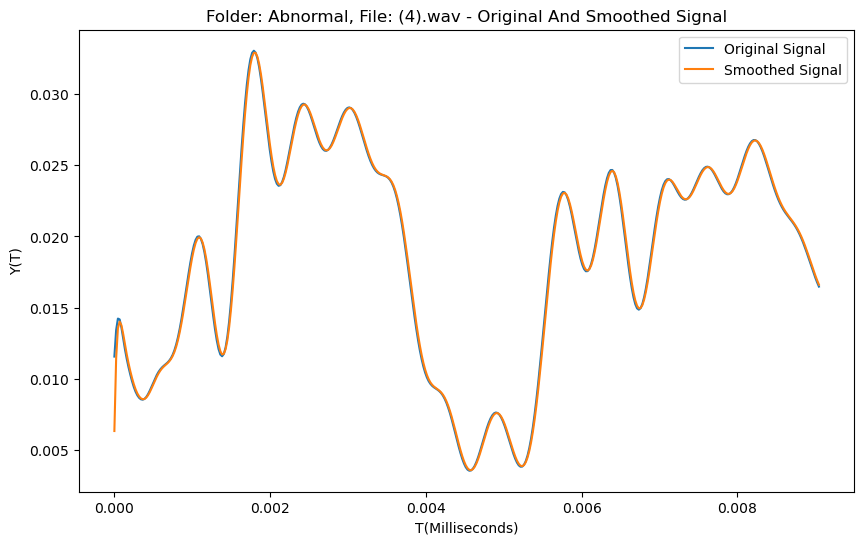

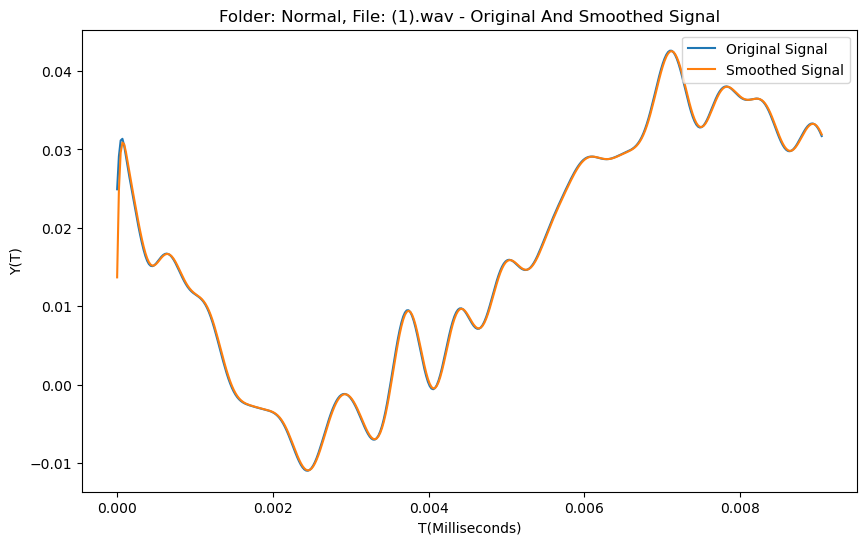

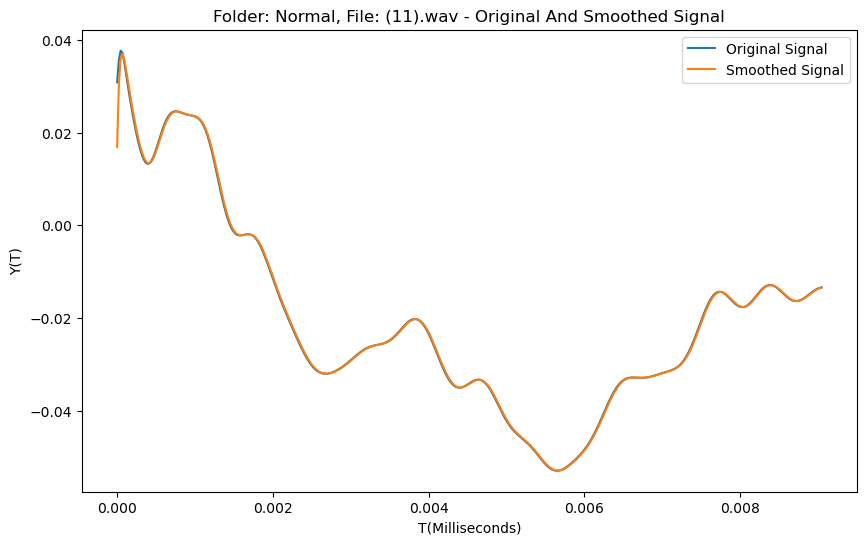

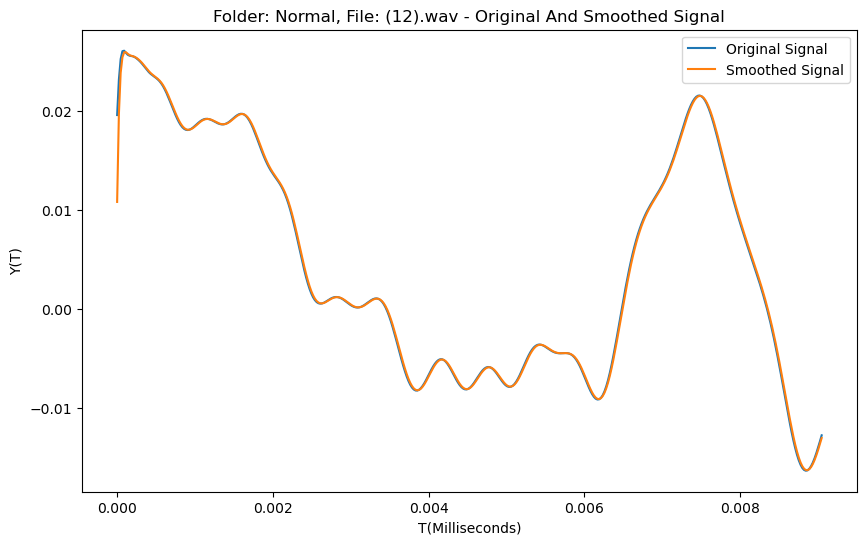

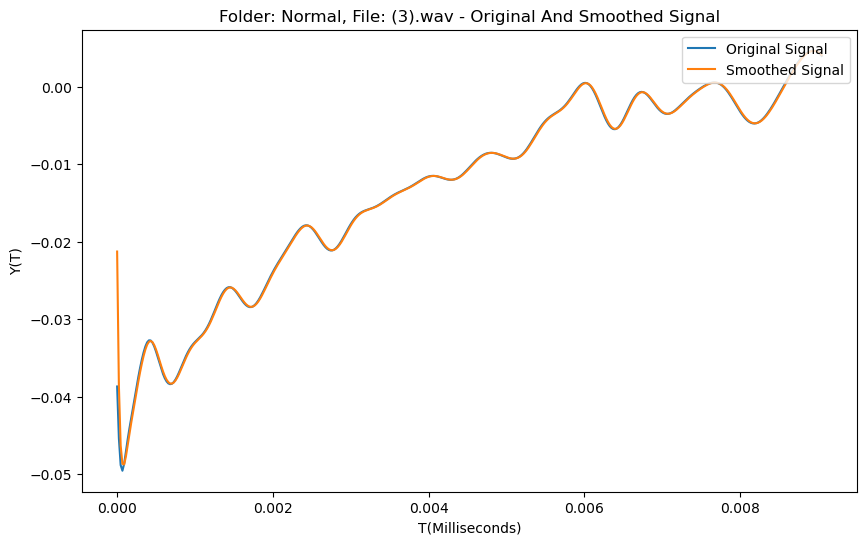

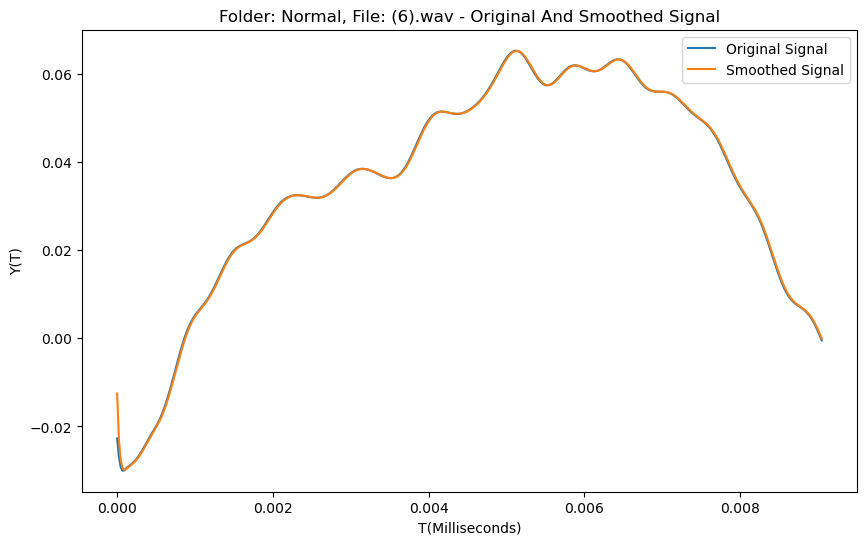

In [33]:
# Plotting the Smoothed Signal
for i, (t, x) in enumerate(data):
    #Convolving Signal With Gaussian Kernel
    S_smoothed = np.convolve(norm_gaussian_kernel, x, mode = 'same')

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    #Plotting First 400 Points Of Original And Smoothed Signal
    plt.figure(figsize = (10, 6))
    plt.plot(t[:400], x[:400], label = 'Original Signal')
    plt.plot(t[:400], S_smoothed[:400], 'tab:orange', label = 'Smoothed Signal')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Original And Smoothed Signal')
    plt.xlabel('T(Milliseconds)')
    plt.ylabel('Y(T)')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.show()

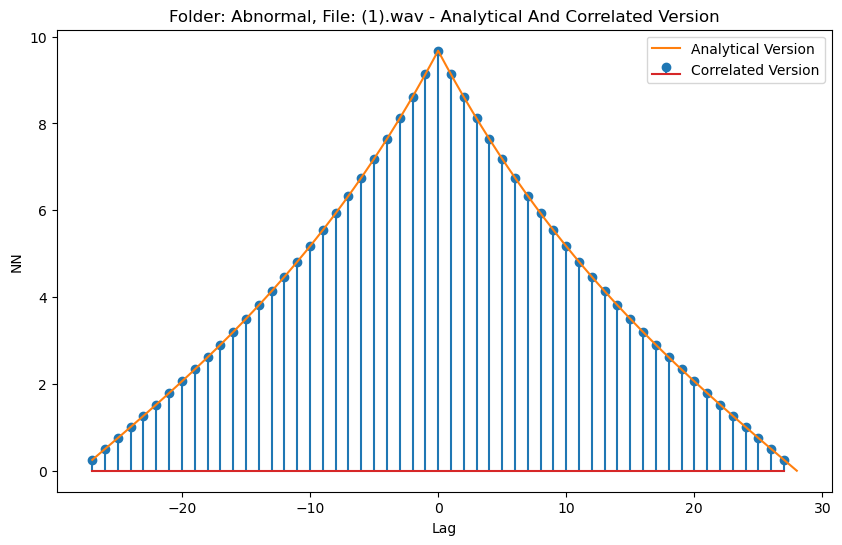

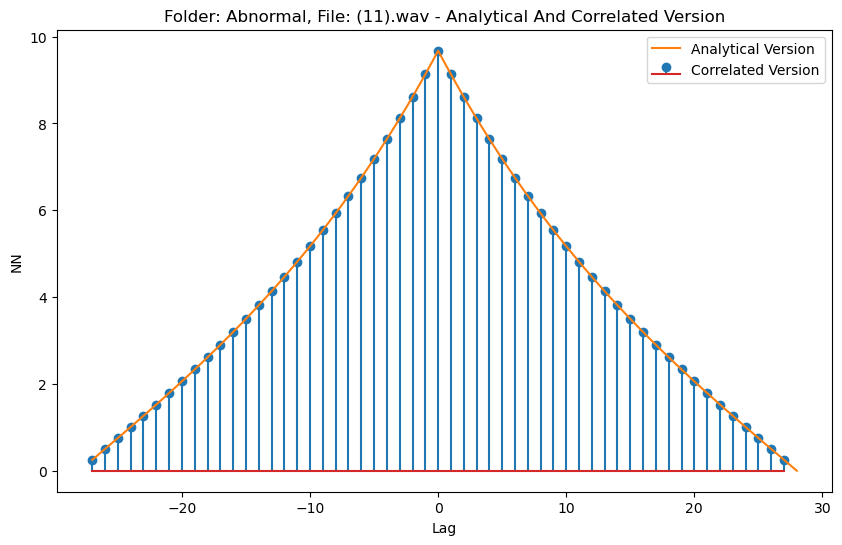

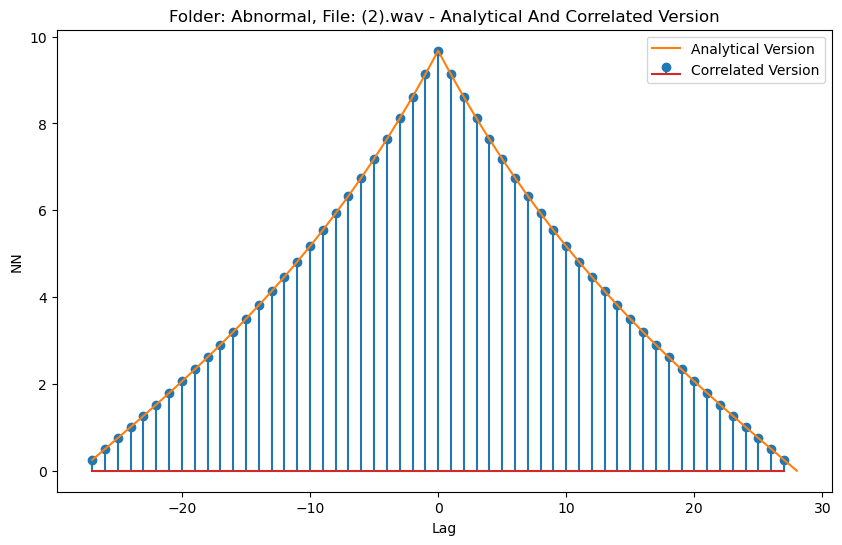

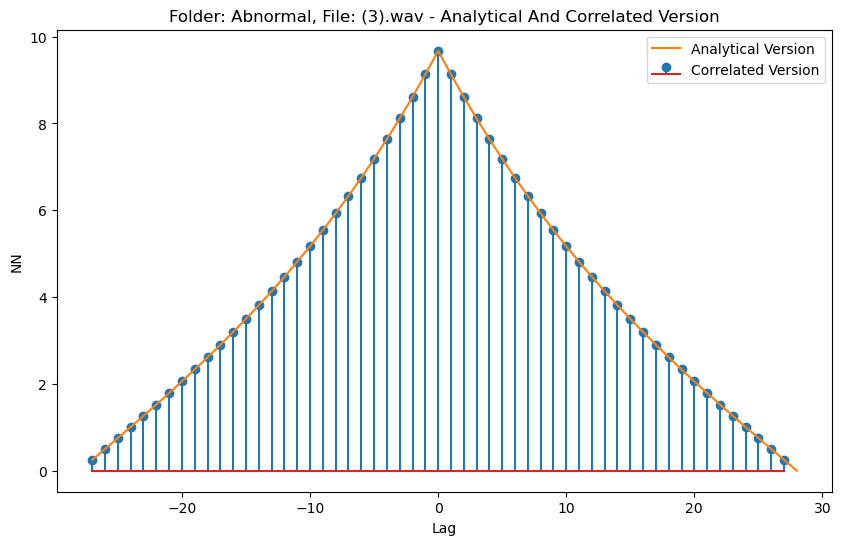

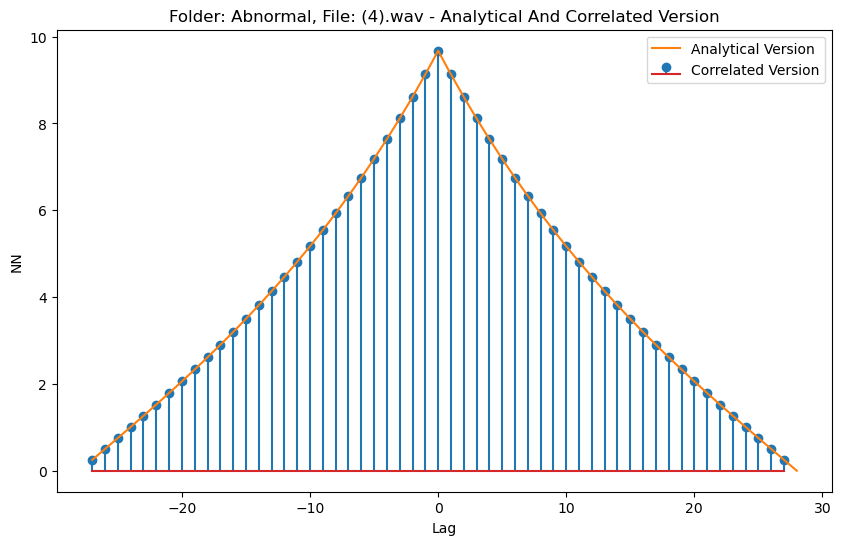

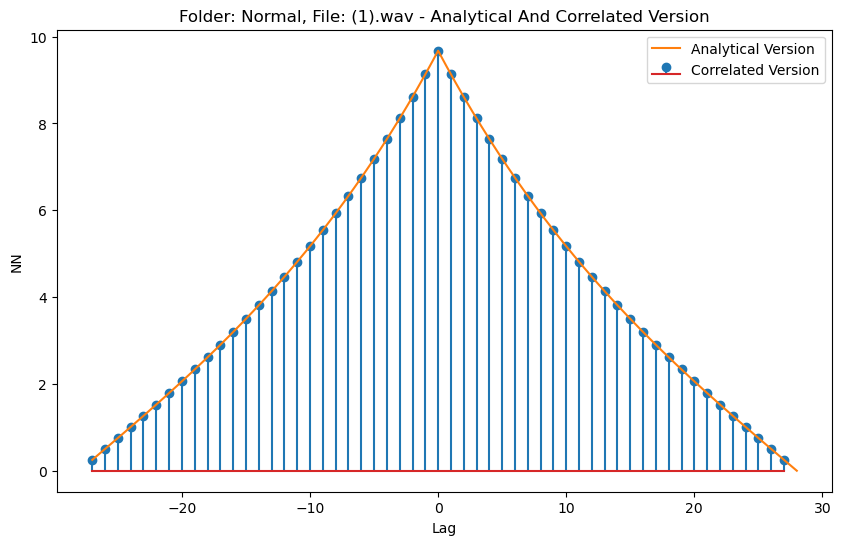

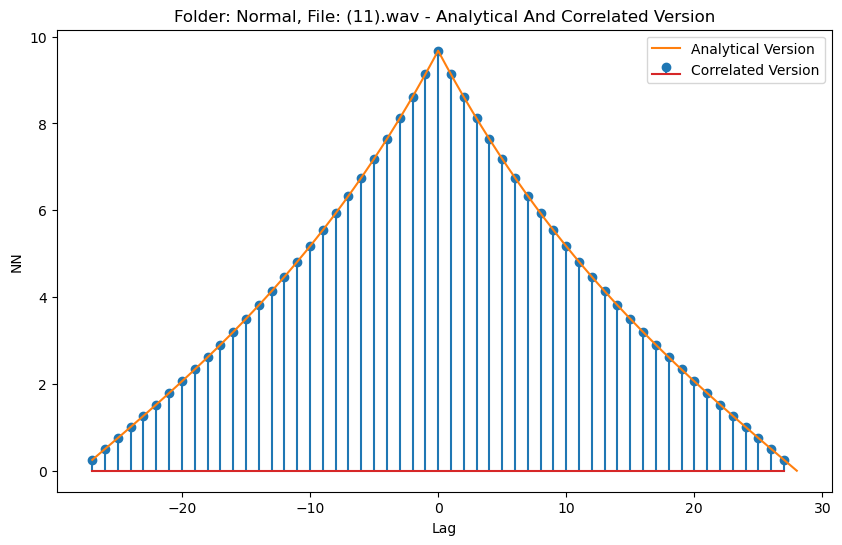

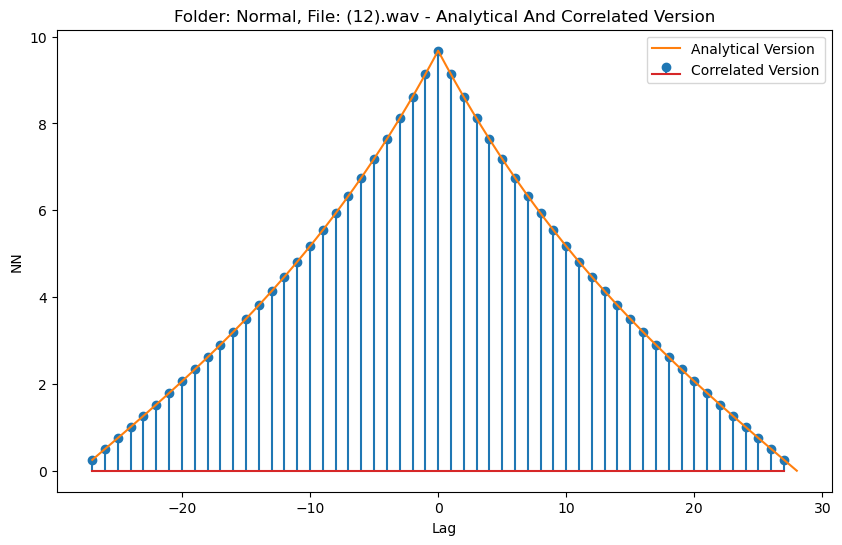

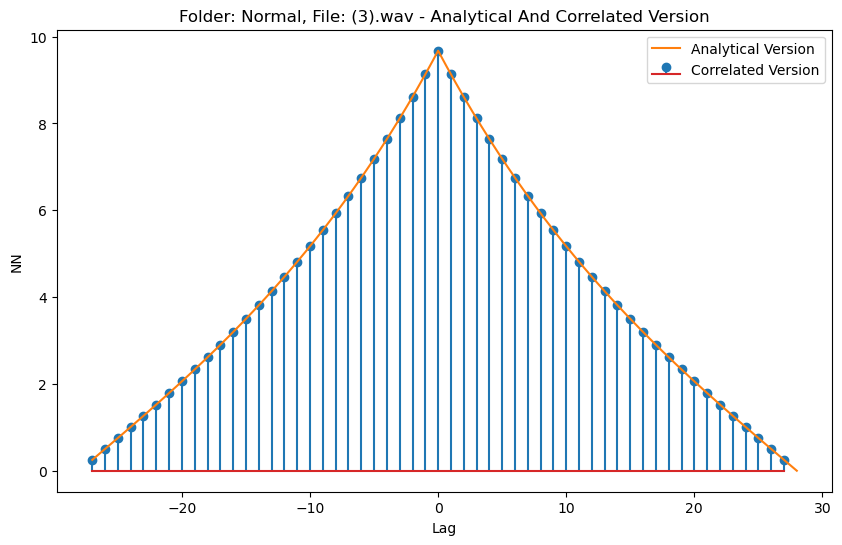

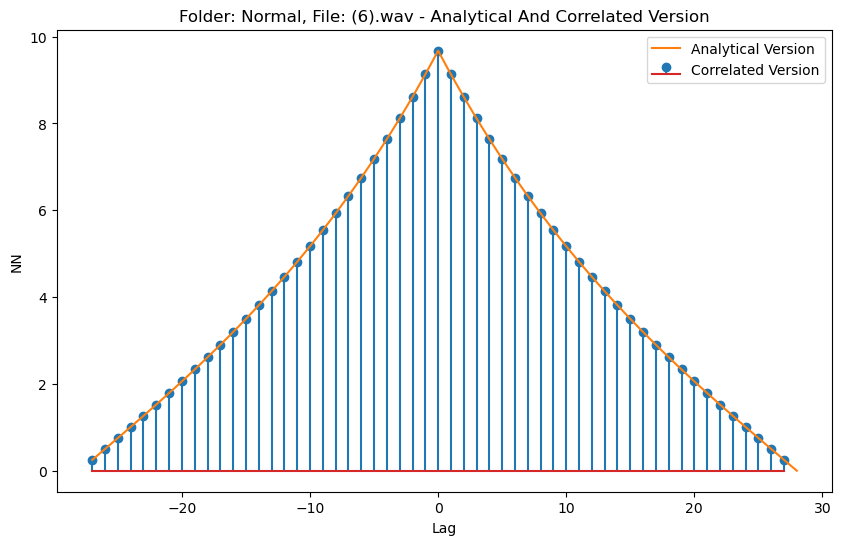

In [36]:
for i, (t, x) in enumerate(data):
    a = 0.95
    N = 28
    n = np.arange(0, N)
    lags = np.arange(-(N-1), N)

    s = a ** n
    c_auto_corr = np.correlate(s, s, mode = 'full')

    #C Analytically Estimated
    nn = np.arange(-(N-1), N, 1/fs)
    c_analytical = (1 - a**(2*(N-np.abs(nn)))) / (1 - a**2) * a**np.abs(nn)

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    #Plotting Analytical And Correlated Version
    plt.figure(figsize = (10, 6))
    plt.stem(lags, c_auto_corr, label = 'Correlated Version')
    plt.plot(nn, c_analytical, 'tab:orange', label = 'Analytical Version')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Analytical And Correlated Version')
    plt.xlabel('Lag')
    plt.ylabel('NN')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.show()

In [17]:
M = 128 # Window Length
g = hann(M, sym=False)  # window
L = 0.75*M  # window Overlap
Ndft = 128 

C:\Users\envy\AppData\Local\Temp\ipykernel_3280\266009800.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(tx, fx, 10 * np.log10(np.abs(sx)), shading='auto')


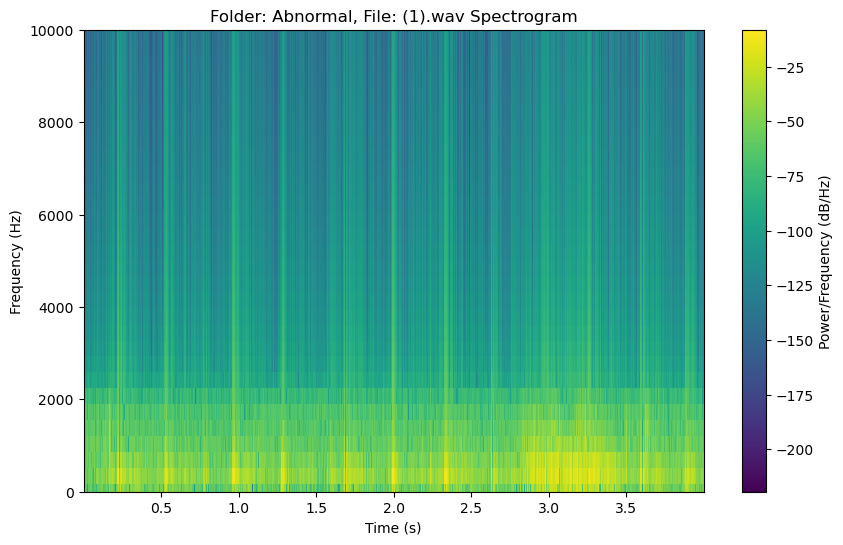

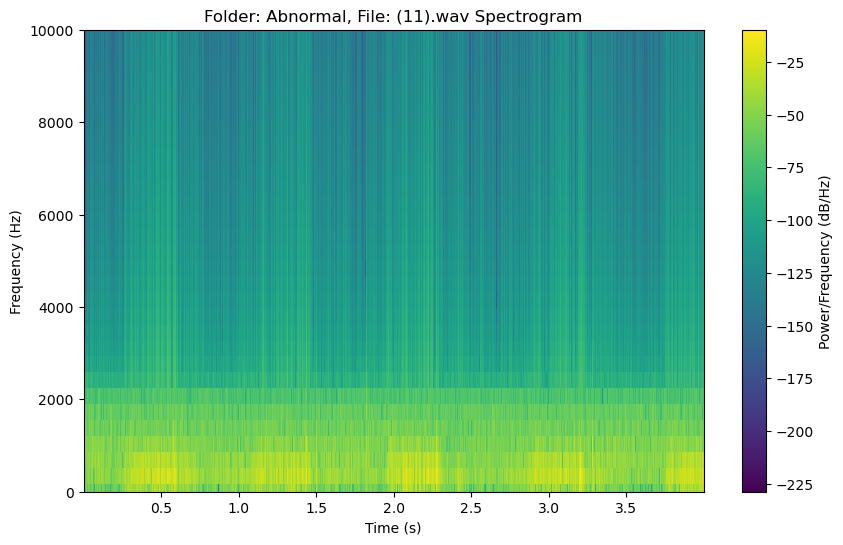

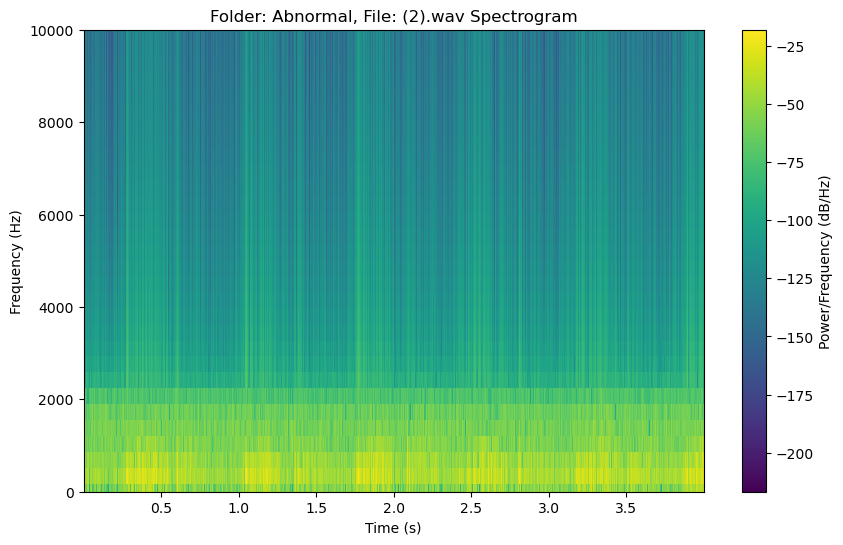

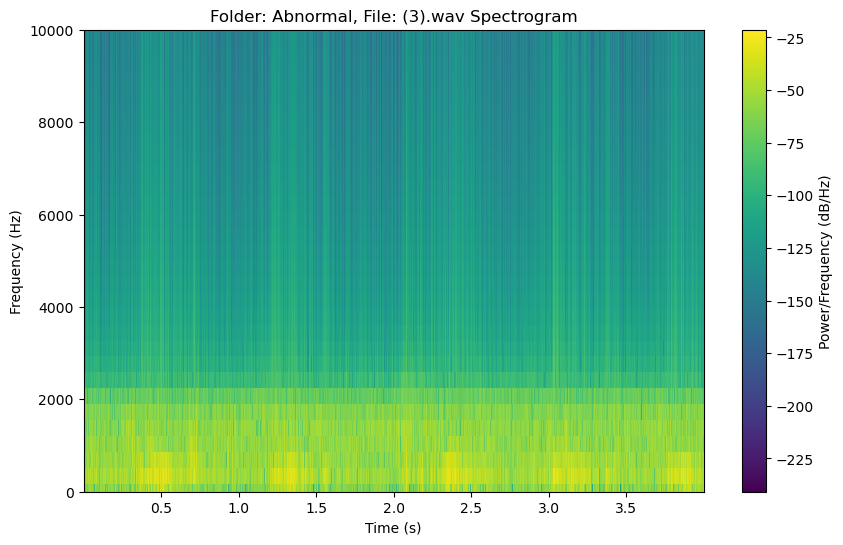

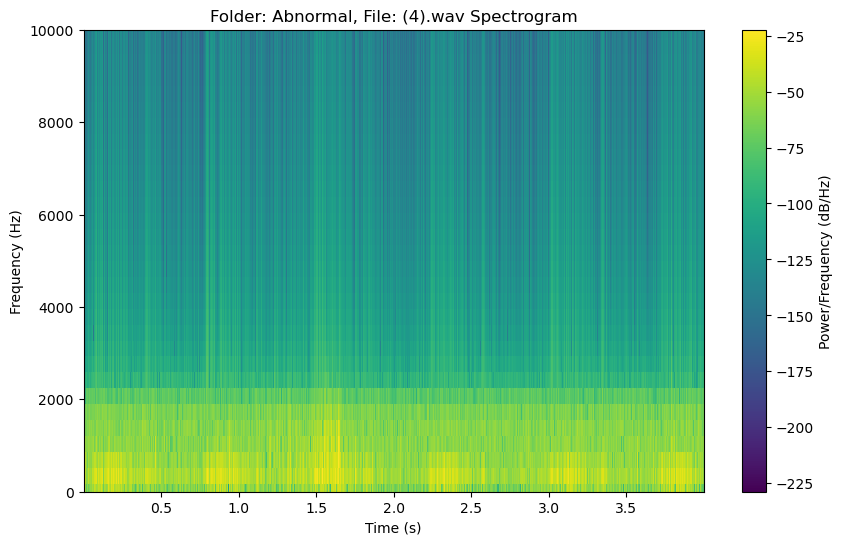

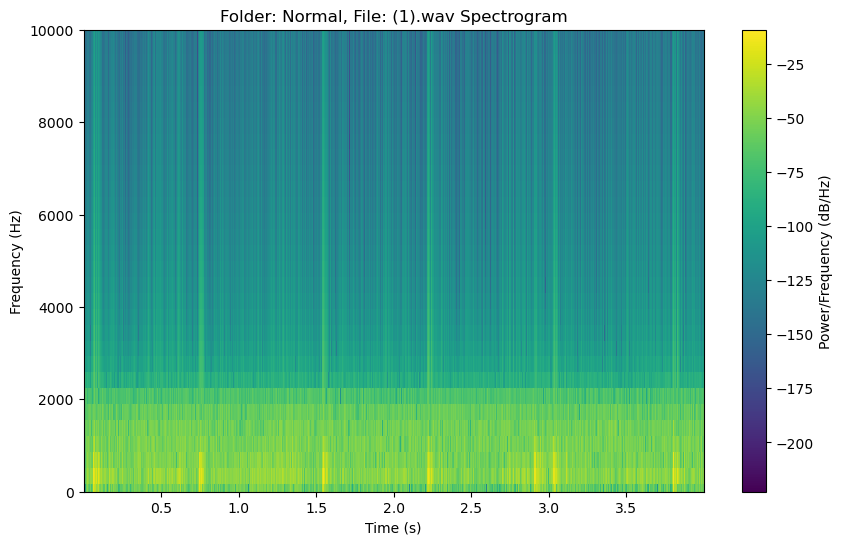

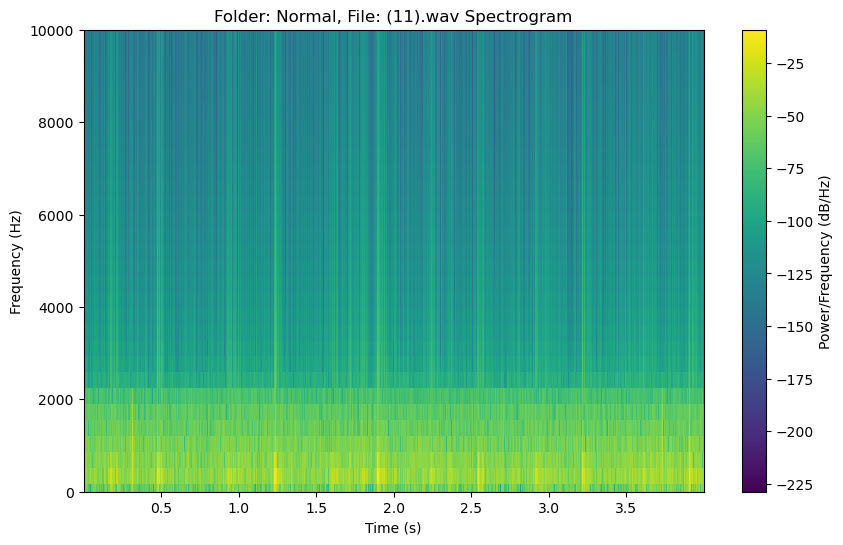

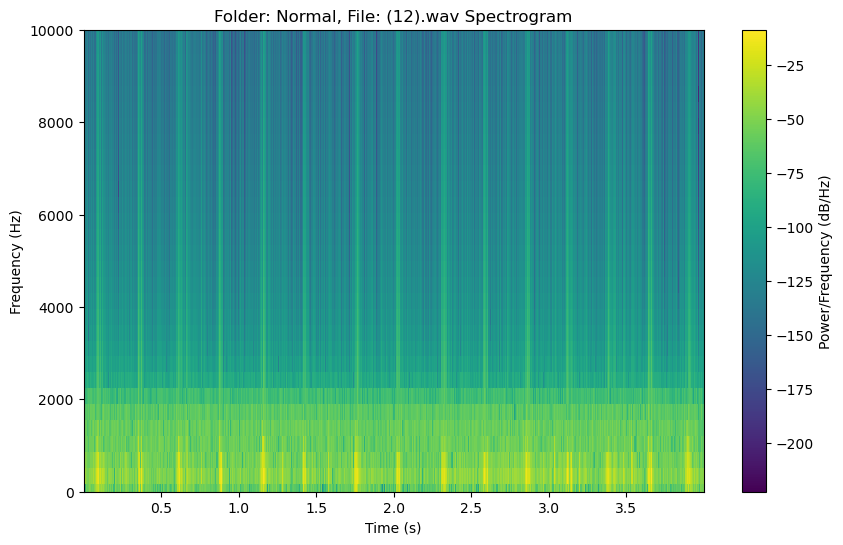

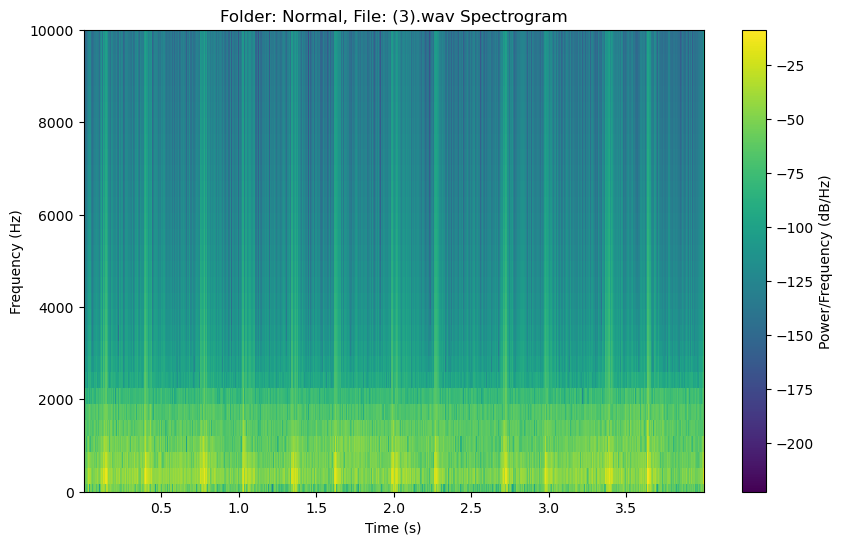

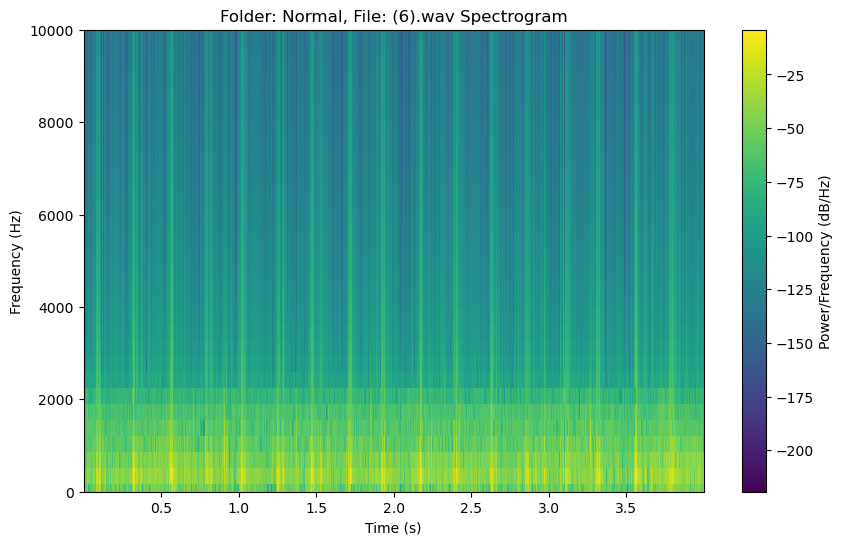

In [49]:
# Define the frequency range you want to zoom into
freq_min = 0  # Minimum frequency in Hz
freq_max = 10000  # Maximum frequency in Hz

# Plot the spectrogram
for i, (t, x) in enumerate(data):
    fx, tx, sx = spectrogram(x, fs=fs, window=g, nperseg=M, noverlap=int(L), nfft=Ndft, scaling='spectrum')

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(tx, fx, 10 * np.log10(np.abs(sx)), shading='auto')
    plt.title(f'Folder: {folder_name}, File: {file_name} Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')

    # Set frequency limits
    plt.ylim(freq_min, freq_max)  # Zoom into the specified frequency range
    plt.show()


C:\Users\envy\AppData\Local\Temp\ipykernel_3280\3592632827.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(tt, ft, 10 * np.log10(np.abs(st)), shading='auto')  # Convert to dB


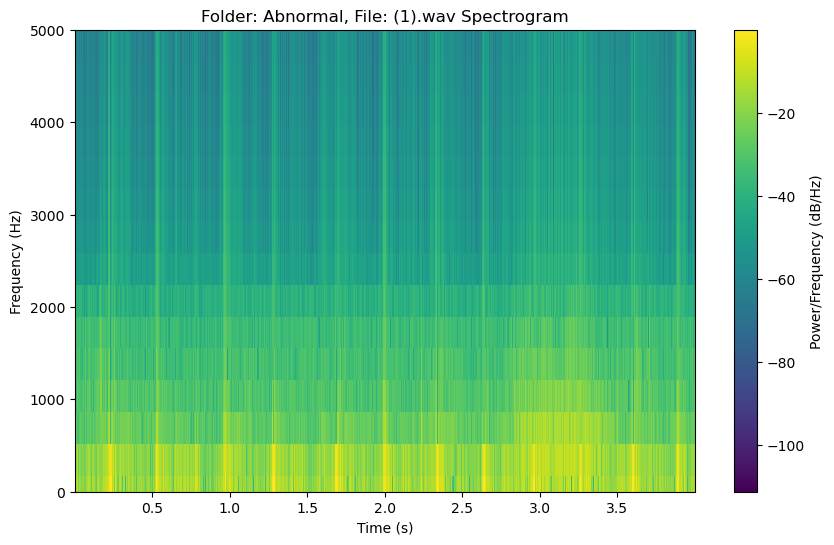

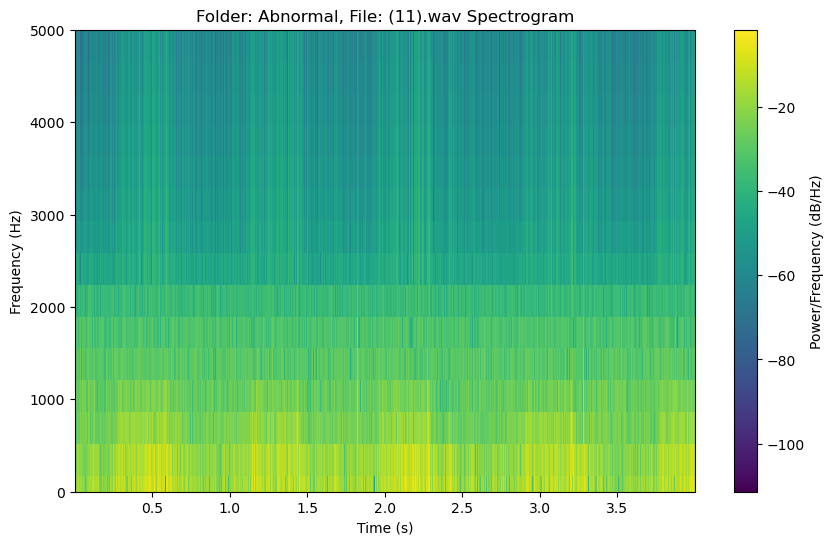

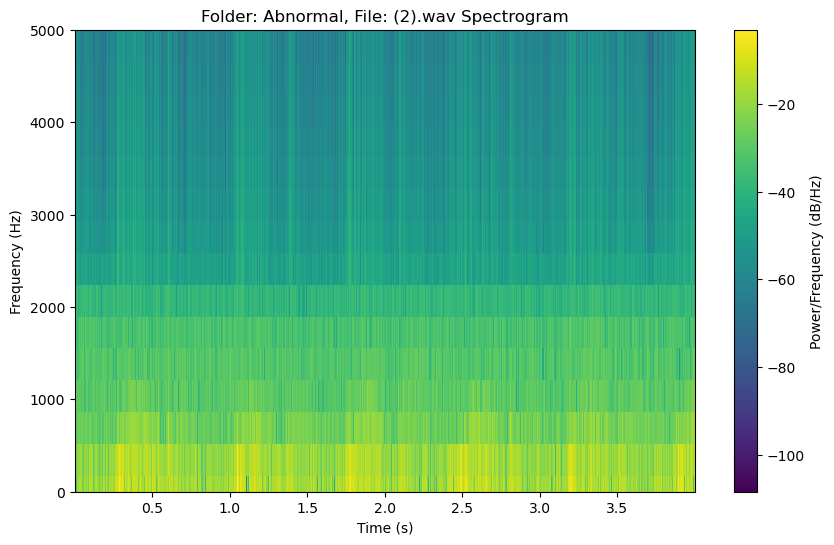

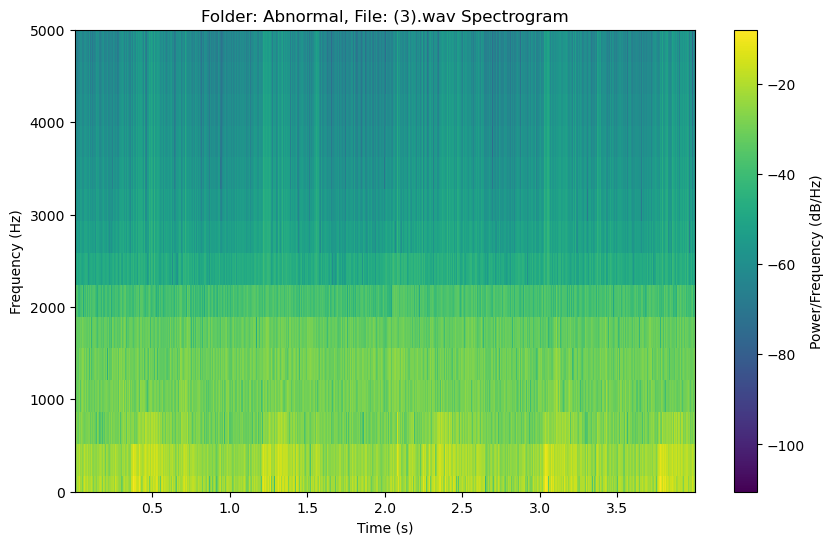

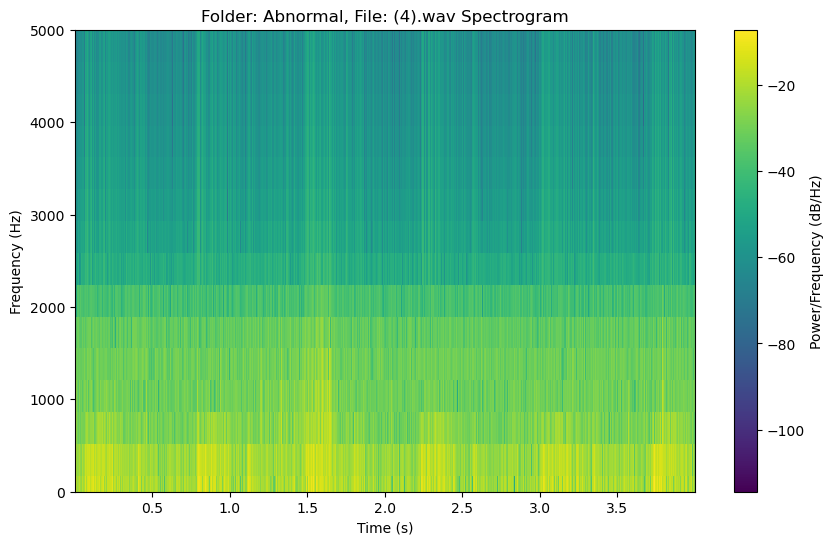

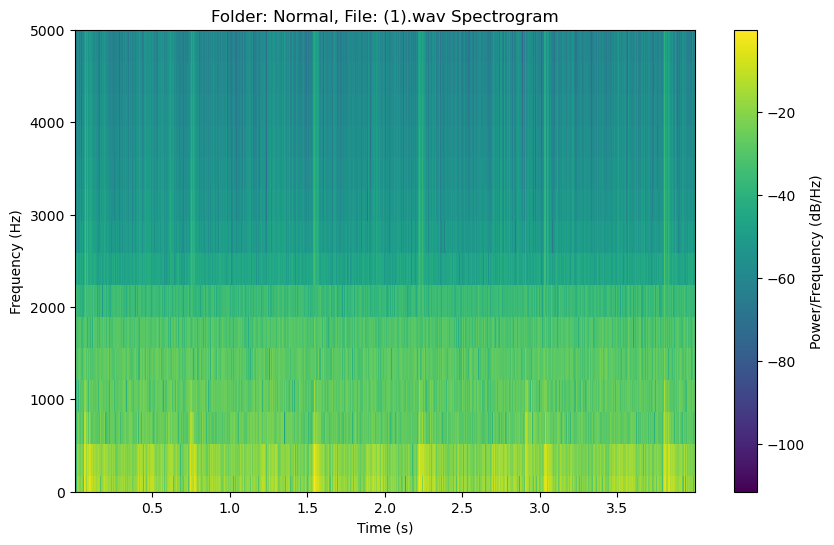

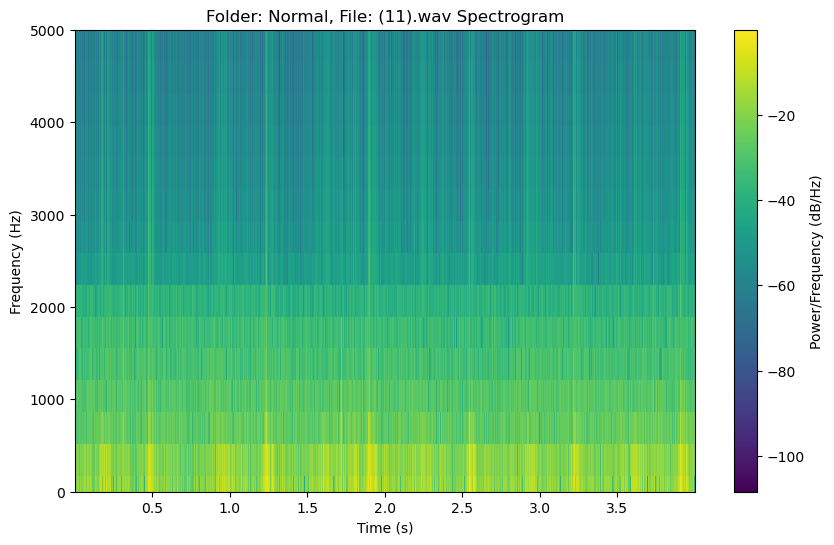

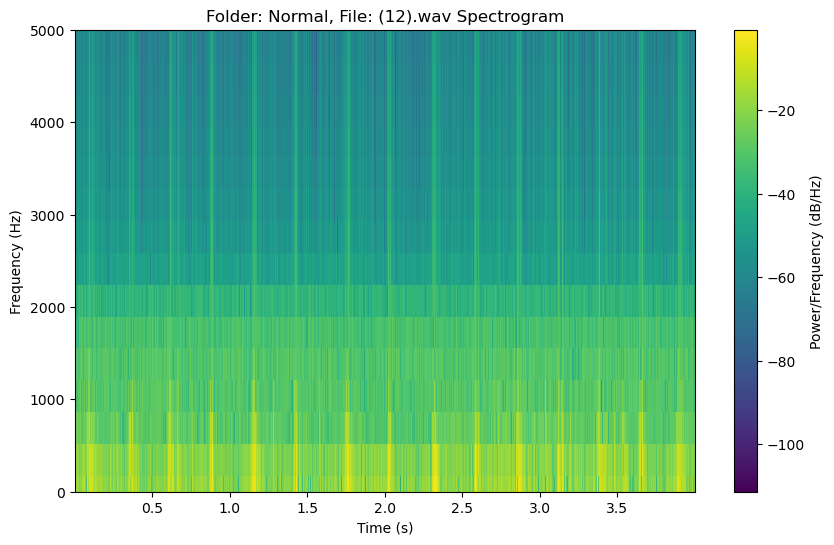

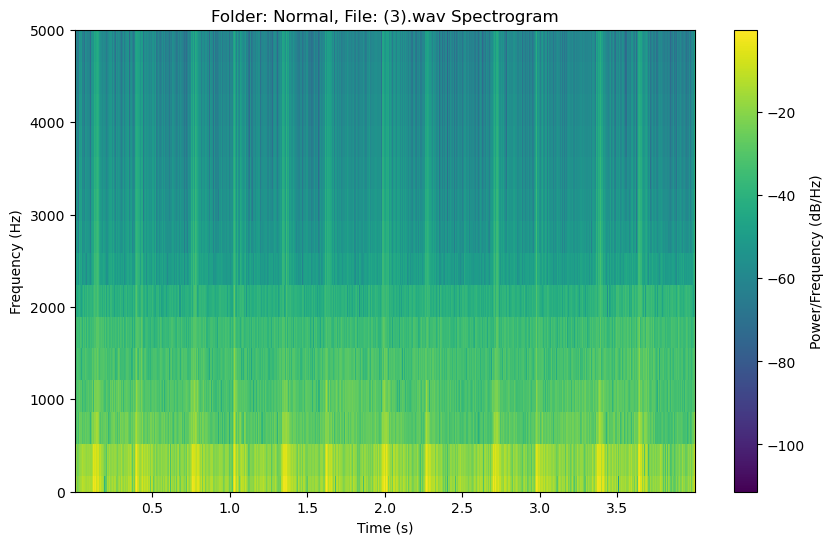

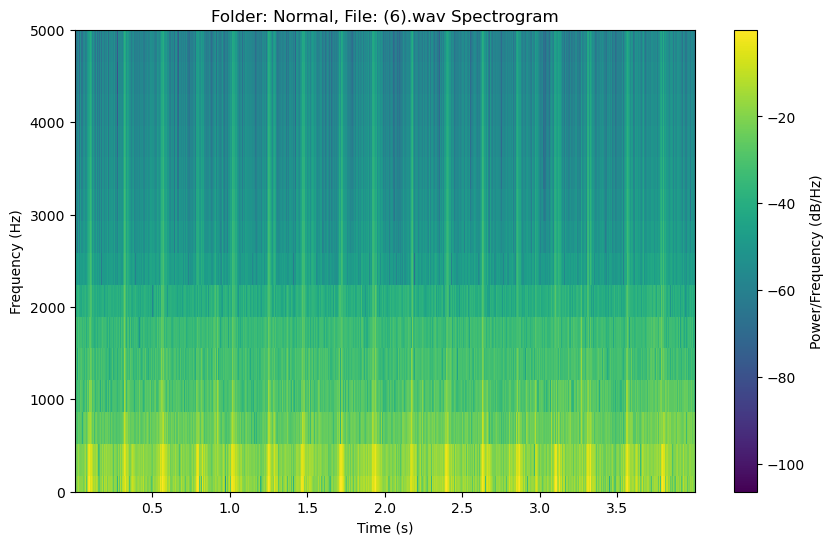

In [50]:
# Plot the STFT
for i, (t, x) in enumerate(data):
    fx, tx, sx = spectrogram(x, fs=fs, window=g, nperseg=M, noverlap=L, nfft=Ndft, scaling='spectrum')

    # Using the STFT with explicit parameters
    ft, tt, st = stft(x, fs=fs, window=g, noverlap=int(L), nperseg=M, nfft=Ndft, boundary=None, padded=False, scaling="spectrum")

    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(tt, ft, 10 * np.log10(np.abs(st)), shading='auto')  # Convert to dB
    plt.title(f'Folder: {folder_name}, File: {file_name} Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    
    # Optionally set frequency limits
    plt.ylim(0, 5000)  # Adjust these limits to zoom into specific frequencies
    plt.show()


In [55]:
# Using np.random.seed(0) sets the random seed to ensure reproducibility.
np.random.seed(0)

fs = 44100  # Set the sample rate for the heartbeat dataset

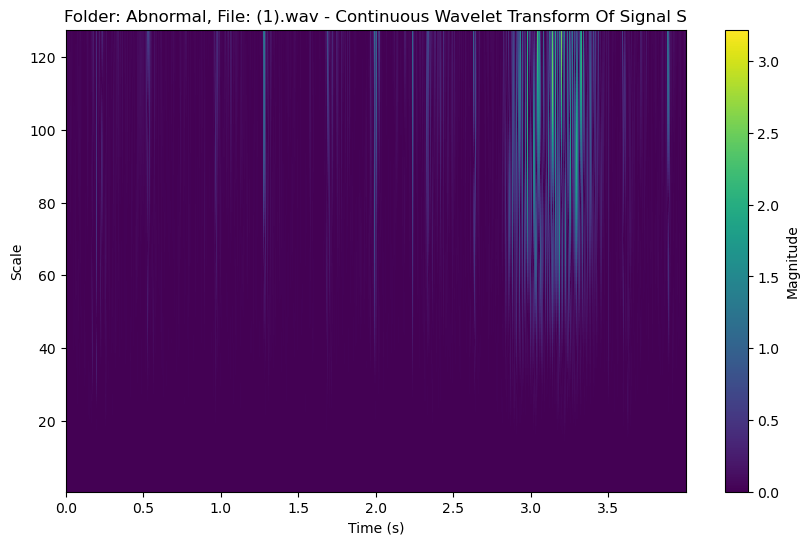

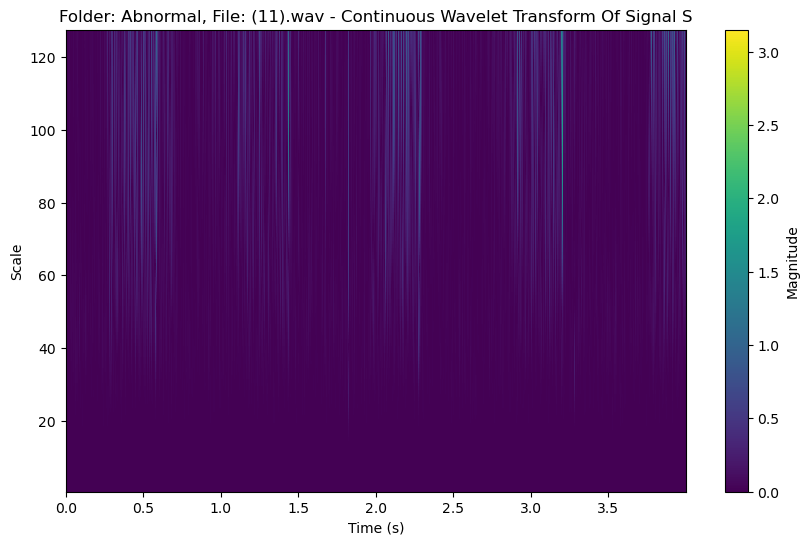

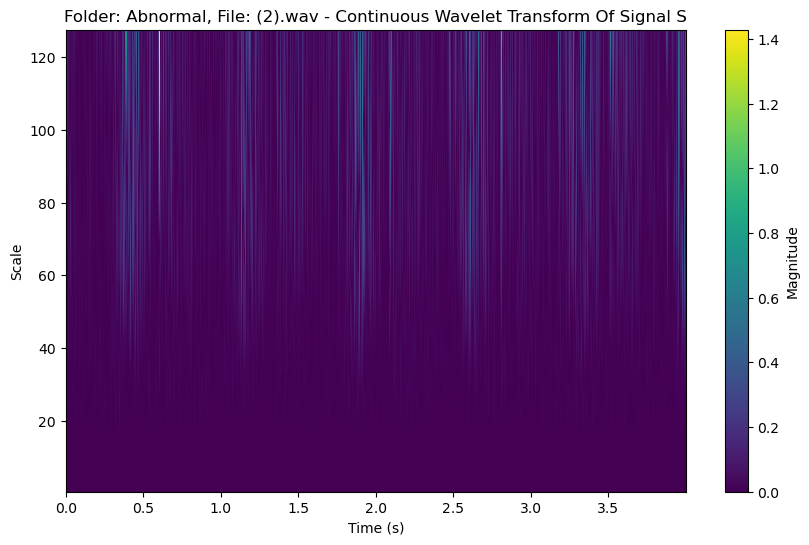

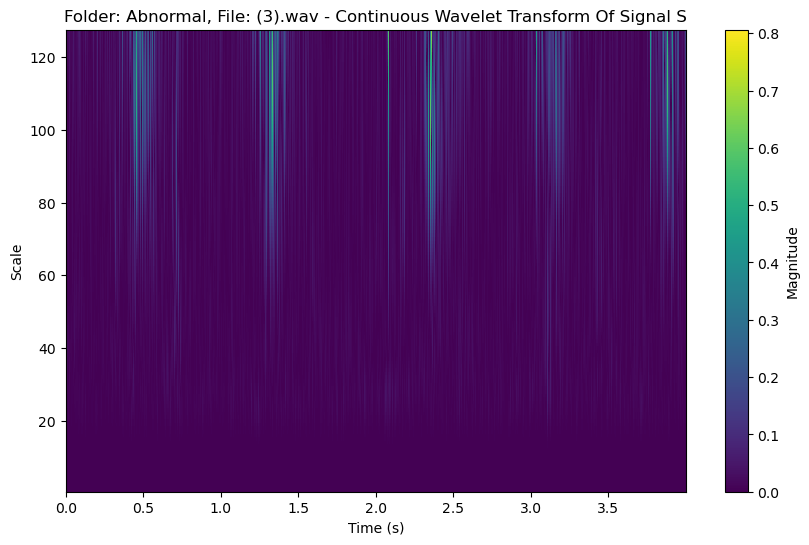

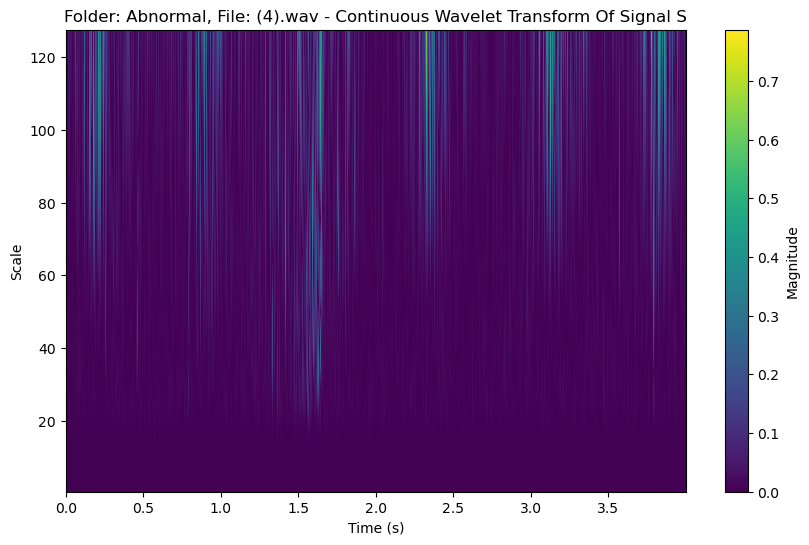

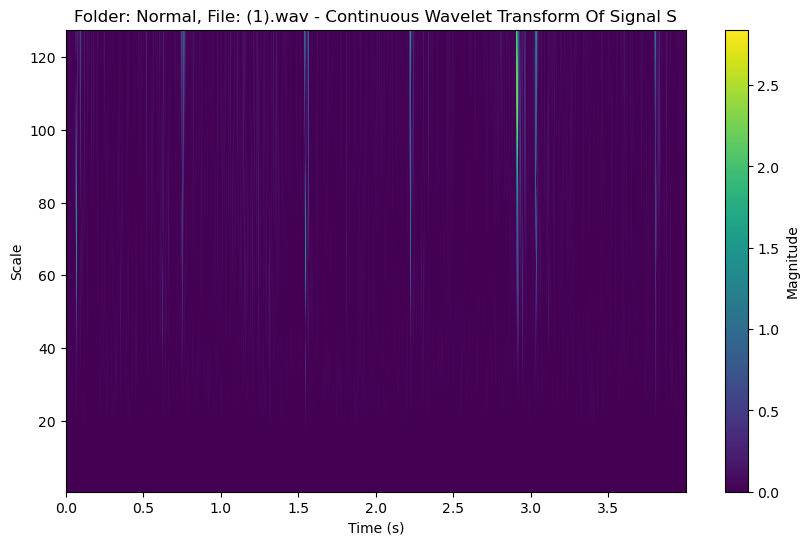

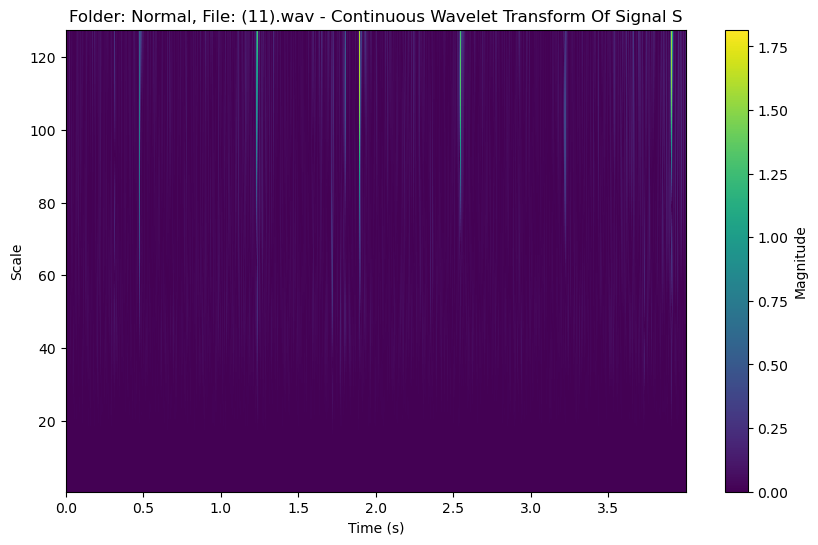

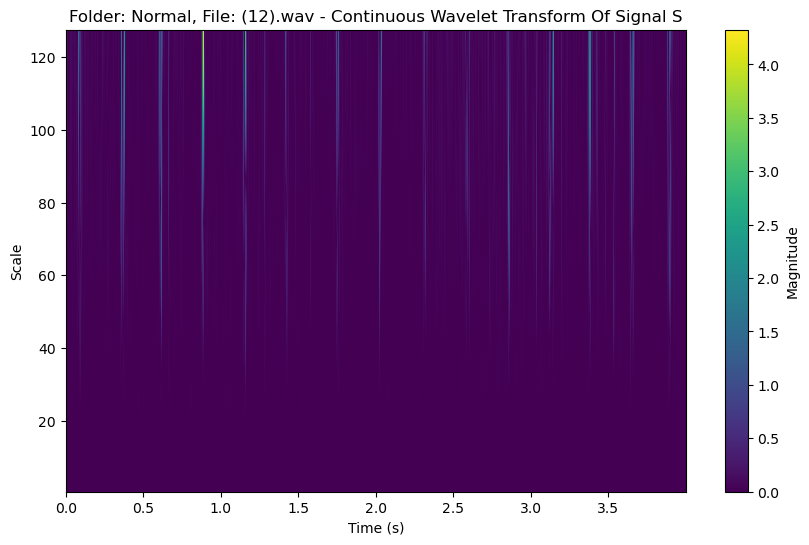

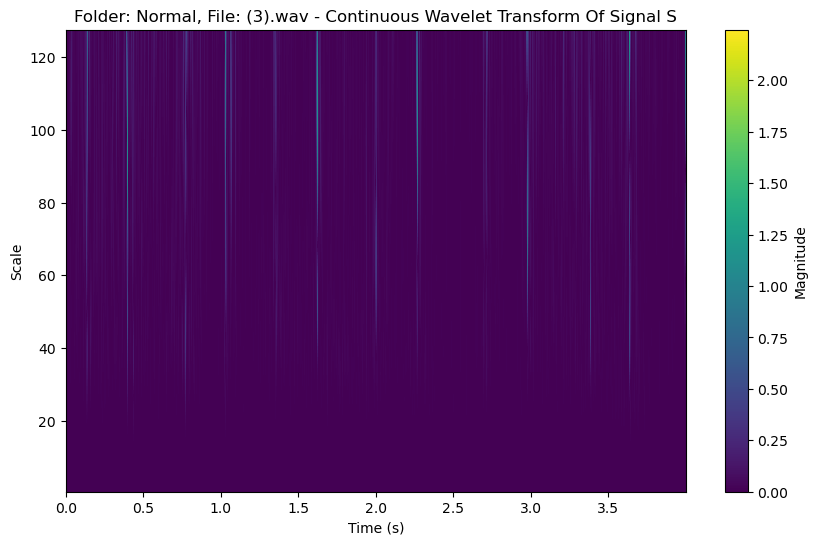

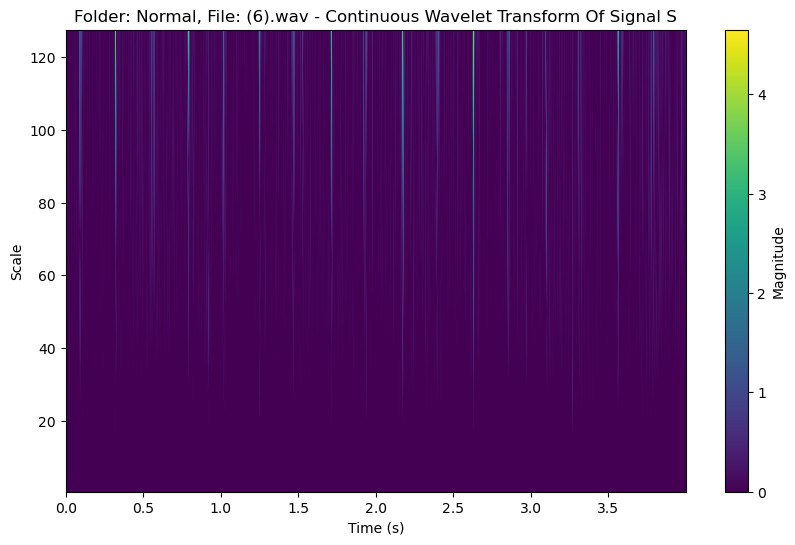

In [58]:
# Loop to perform CWT on each signal
for i, (t, x) in enumerate(data):
    folder_name = os.path.basename(os.path.dirname(file_info[i]))  # Get folder name
    file_name = os.path.basename(file_info[i])  # Get file name

    wavelet = 'morl'  # Define the wavelet
    scales = np.arange(1, 128)  # Define scales
    cwt_results, frequencies = pywt.cwt(x, scales, wavelet)

    # Plot the CWT coefficients
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, scales, np.abs(cwt_results), shading='auto')
    plt.title(f'Folder: {folder_name}, File: {file_name} - Continuous Wavelet Transform Of Signal S')
    plt.xlabel('Time (s)')
    plt.ylabel('Scale')
    plt.colorbar(label='Magnitude') 
    plt.show()
